<a href="https://colab.research.google.com/github/VictorrLiu/Draft_notebooks/blob/main/Visium_HD_Workshop_Part2_Practice_multi_sample_integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: 10x Genomics does not provide support for community-developed tools and makes no guarantees regarding their function or performance. Please contact tool developers with any questions.*

This notebook is for practice in workshop with some codes missing.

**If you want to access a full and complete notebook with all codes filled in**, please use this link [here](https://colab.research.google.com/github/10XGenomics/analysis_guides/blob/main/Visium_HD_multi_sample_integration.ipynb)

# **Section 1. Install packages**

## **Section 1.a Install packages directly from R repositories. **

This takes very long time

**Not recommended in workshop**

It's recommended if you plan to run these analyses in your own computing system. It's always good to keep your packages always updated.

In [ ]:
system("sudo apt-get install libmagick++-dev")
install.packages("Seurat")
install.packages("harmony")
remotes::install_github('satijalab/seurat-wrappers')
devtools::install_github('immunogenomics/presto')
remotes::install_github("bnprks/BPCells/r")
install.packages("hdf5r")

## **Section 1.b Install packages by directly downloading pre-installed packages from AWS s3 bucket - R **
Recommended in a workshop as it's faster.

In [ ]:
system("wget https://cf.10xgenomics.com/supp/xenium/analysis-workshop/R_library_v4-5.tar.gz")

# move all pre-installed R packages to default R folder path
system("tar -xzvf /content/R_library_v4-5.tar.gz")
system(paste0("cp -r /content/R_library_v4-5/* ", .libPaths()[1]))

# Section 2. Download practice datasets

Here, we are using two Visium HD samples generated from the same clinical sample, one is colon cancer tissue and the other is normal adjacent tissue. The two Visium HD samples used in this notebook can be found [here](https://www.10xgenomics.com/products/visium-hd-spatial-gene-expression/dataset-human-crc) (Sample P5 CRC and Sample P5 NAT).



Visium HD sample can be very large. The two samples we are working with have in total ~1 million 8um bins. If analyzing full datasets, the memory required to store the expression matrices can present a challenge. Here we use Seurat sketch to subsample bins from each large Visium HD sample while preserving rare populations (see detailed Seurat sketch tutorial for multi-sample integration [here](https://satijalab.org/seurat/articles/parsebio_sketch_integration)). Then we will remove batch effects using Harmony, which is one of the top performing tools for bacth correction ([Tran, et al., 2020](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1850-9)).

We will need `filtered_feature_bc_matrx.h5` from the Space Ranger outputs in order to perform integration. For example, if integrating 8um bins across mulltiple samples, we will need `binned_outputs/square_008um/filtered_feature_bc_matrix.h5` from each sample. We will also need `binned_outputs/square_008um/filtered_feature_bc_matrix/features.tsv.gz`. The purpose of the features.tsv.gz file will be explained below.

In the code block below, we are downloading `filtered_feature_bc_matrix.h5` and `features.tsv.gz` 8um binned data for each Visium HD sample.


In [ ]:
system("wget https://cf.10xgenomics.com/supp/spatial-exp/analysis-workshop/visium_hd_multisample.tar.gz")
system("tar -xzvf /content/visium_hd_multisample.tar.gz")
system("mv /content/visium_hd_multisample/Colon_Cancer_P5_008um /content/Colon_Cancer_P5_008um")
system("mv /content/visium_hd_multisample/Colon_Normal_P5_008um /content/Colon_Normal_P5_008um")

# Section 3. Create on-disk matrices for both Visium HD data

In [ ]:
library(Seurat)
library(ggplot2)
library(BPCells)
library(SeuratWrappers)
# this is needed for large datasets
options(future.globals.maxSize = 1e10)

In [ ]:
# load colon cancer data
colon_cancer <- open_matrix_10x_hdf5(
  path = "/content/Colon_Cancer_P5_008um/filtered_feature_bc_matrix.h5",
  feature_type = "Gene Expression"
)

# Write the colon cancer matrix on disk
write_matrix_dir(mat = colon_cancer,
                 dir = "/content/colon_cancer_matrix",
                 overwrite = TRUE)

In [ ]:
# load colon normal data
colon_normal <- open_matrix_10x_hdf5(
  path = "/content/Colon_Normal_P5_008um/filtered_feature_bc_matrix.h5",
  feature_type = "Gene Expression"
)

# Write the colon normal matrix on disk
write_matrix_dir(mat = colon_normal,
                 dir = "/content/colon_normal_matrix",
                 overwrite = TRUE)

Now we have matrix on disk. We can load on-disk matrix.

Since there are multiple samples in this demo, it's a good practice to make bin IDs unique across all integrated samples. Here, we add suffix to bin IDs. For example, we add ".cancer" suffix to each bin ID in colon cancer data and ".normal" suffix to each bin ID in colon normal data.

By default, gene Ensembl IDs are used in output matrix. Ensembl IDs are not intuitive. Here we can convert Ensembl IDs to gene names. For each Visium bin outoput, there is a file `features.tsv.gz` which contains matched gene name for each gene Ensembl ID used in this data. We can use this file for conversion.

In [ ]:
# load on-disk matrix of colon cancer data
colon_cancer_count <- open_matrix_dir(dir = "/content/colon_cancer_matrix")

# add ".cancer" suffix to barcode IDs
colnames(colon_cancer_count) <- paste(colnames(colon_cancer_count),"cancer",sep = ".")

# convert Ensembl IDs to gene names
features <- read.table("/content/Colon_Cancer_P5_008um/features.tsv.gz",
                       sep="\t", header=FALSE)
features <- features[(features$V3 == "Gene Expression"),]
features <- features[match(rownames(colon_cancer_count), features$V1),]
rownames(colon_cancer_count) <- features$V2

In [ ]:
# we do the same thing for conlon normal data

# load on-disk colon normal matrix
colon_normal_count <- open_matrix_dir(dir = "/content/colon_normal_matrix")

# add ".normal" suffix to barcode IDs
colnames(colon_normal_count) <- paste(colnames(colon_normal_count),"normal",sep = ".")

# convert Ensembl IDs to gene names
features <- read.table("/content/Colon_Normal_P5_008um/features.tsv.gz",
                       sep="\t", header=FALSE)
features <- features[(features$V3 == "Gene Expression"),]
features <- features[match(rownames(colon_normal_count), features$V1),]
rownames(colon_normal_count) <- features$V2

# Section 4. Create a Seurat object (having both Visium HD samples) with on-disk matrix

In [ ]:
# create a list having both colon cancer and normal on-disk matrices
countlist <- list(colon_cancer_count, colon_normal_count)
names(countlist) <- c("cancer","normal")

### **Task 1**

Create a Seurat object containing the list of cancer and normal on-disk matrices

We can simply use `CreateSeuratObject` on the list of matrices `countlist` to create a Seurat object.

In [ ]:
# create a Seurat object for both colon cancer and normal data
merge.obj <- ADD_YOUR_CODE_HERE

In [ ]:
merge.obj

An object of class Seurat 
18082 features across 977741 samples within 1 assay 
Active assay: RNA (18082 features, 0 variable features)
 2 layers present: counts.cancer, counts.normal

Since bins from both colon cancer and normal data are in one Seurat object, let's add one column `sample` to Seurat meta.data showing sample origin for each bin.

In [ ]:
samples <- sapply(strsplit(colnames(merge.obj),"\\."),function(X){return(X[2])})
merge.obj$samples <- samples

# Section 5. "Sketch" subsampled bins and load these bins in memory

The first step is QC. We want to remove bins with low UMI counts. Here we plot distribution of UMI count per 8um bin in a histogram plot and based on it decide lower cutoff in transcript counts (aiming to remove bins with low UMIs). The determination of lower cutoff can be subjective. There is no gold-standard rule.  

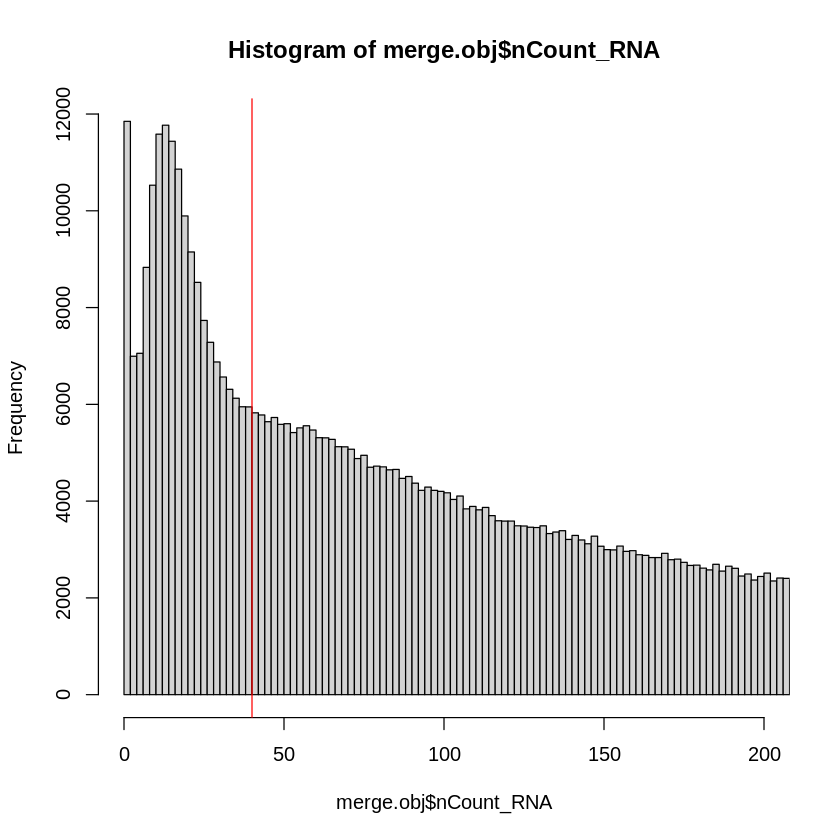

In [ ]:
# based on the histogram plot, here we choose 40 transcript counts as lower cutoff
hist(merge.obj$nCount_RNA, xlim=c(0,200), breaks = 5000)
abline(v = 40, col="red")

In [ ]:
## QC
## filtering bin based on detected UMIs per bin
## Upper limit cutoff - 98th percentile
## Lower limit cutoff - 40
# runtime: 23s
thres <- quantile(merge.obj$nCount_RNA, c(0.98))
merge.obj <- subset(merge.obj, subset = nCount_RNA >= 40 & nCount_RNA <= thres[1])

### **Task 2**

Data normalization

We can use `NormalizeData` function to do normalization
-  scale.factor: median(merge.obj$nCount_RNA) - *`merge.obj$nCount_RNA` contains total transcript counts for each cell*

In [ ]:
## Normalization
## library size based normalization, scale factor - median transcript count
## runtime: 28s
merge.obj <- ADD_YOUR_CODE_HERE

### **Task 3**

Feature selection

We can use `FindVariableFeatures` function to do feature selection

In [ ]:
## Find top 2k variable genes
# runtime: 16s
merge.obj <- ADD_YOUR_CODE_HERE

In the next section, we will subsample (sketch) bins from all bins so that our data are more manageable. We will downsample both of our samples to 25,000 bins. This number was selected for demonstration purposes. You will need to consider how many bins you have for each sample and how many would still be representative of the entire dataset when deciding on the downsample number.

This step takes 3-4 mins.

**For in-person events, we will skip this step and directly load the pre-generated result from this step.**

In [ ]:
############################ SKIP this step for in-person events ###################################
## you will need to change ncells (downsample number) based on bin number you have per sample
## ncells = 25000 (meaning selecting 25k bins for each of two data);
## if we set ncells = c(25000, 35000), it will downsample 25k for colon cancer data and 35k for normal data
## runtime: 3mins
merge.obj <- SketchData(merge.obj, ncells = 25000,
                        method = "LeverageScore",
                        sketched.assay = "sketch",
                        features = VariableFeatures(merge.obj))

In [ ]:
##################### load pre-generated result during in-person events ###########################
merge.obj <- readRDS("/content/visium_hd_multisample/backup/HD_integration_after_SketchData.rds")

# Section 6. Conventional data processing

Now we are doing analysis on the representative 50k bins (in `sketch` assay) downsampled from all bins (in `RNA` assay). Since only 50k bins, analysis is much faster. Conventional data processing including: find variable genes, data scaling, and PCA.

In [ ]:
DefaultAssay(merge.obj) <- "sketch"

 ### **Task 4**

 Run the following codes in the correct order

There are three codes below but they are not in the correct order.

Please run each of them sequentially in the correct order.

In [ ]:
# Data scaling
merge.obj <- ScaleData(merge.obj, verbose = FALSE)

In [ ]:
# Run PCA
merge.obj <- RunPCA(merge.obj, verbose = FALSE)

In [ ]:
# Find variable genes
merge.obj <- FindVariableFeatures(merge.obj, verbose = FALSE)

# Section 7. Batch correction by Harmony

In [ ]:
merge.obj

An object of class Seurat 
36164 features across 789975 samples within 2 assays 
Active assay: sketch (18082 features, 2000 variable features)
 5 layers present: counts.cancer, counts.normal, data.cancer, data.normal, scale.data
 1 other assay present: RNA
 1 dimensional reduction calculated: pca

Before doing batch correction, we can check if there are significant batch effects between these two data: project bins in 2D UAMP space without any batch correction and visualize bins by their sample origins. If most of cell types are very well separated between samples in UMAP space, it could indicate batch effects.

In [ ]:
# directly run UMAP on uncorrected PCA results (aka without batch correction)
# runtime: 1min
merge.obj <- RunUMAP(merge.obj, dims = 1:30, reduction = "pca",
                     return.model = TRUE, verbose = FALSE)

 ### **Task 5**

 Plot UMAP without batch correction

We can use `DimPlot` function to plot UMAP.
- group.by: samples - *labeling cells by sample origins*

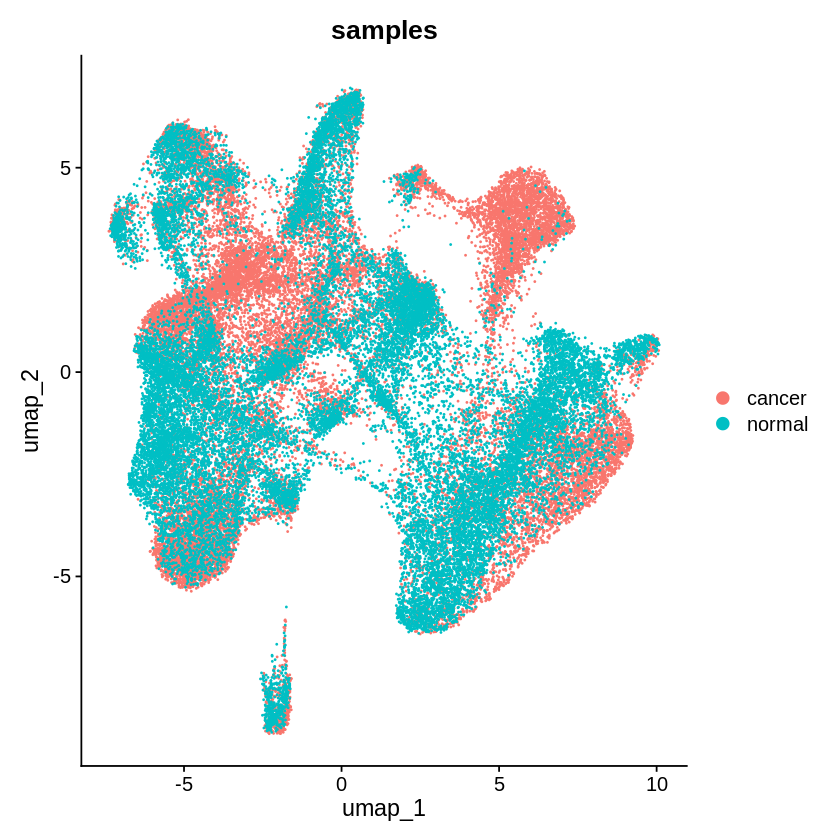

In [ ]:
# plot UMAP and color cells by sample origins
ADD_YOUR_CODE_HERE

If there are significant batch effects, we can use Harmony to correct batch effects. In this demo, we continue doing batch correction using Harmony.

Harmony will correct `PCA` space (which contains variations from batch effects).

After removing batch effects, Harmony will generate new corrected reduced-dimension results, which call  `harmony` space.



In [ ]:
## runtime: 2mins
merge.obj <- IntegrateLayers(merge.obj, method = HarmonyIntegration,
                             orig = "pca", new.reduction = "harmony",
                             dims = 1:30)

In [ ]:
merge.obj

An object of class Seurat 
36164 features across 789975 samples within 2 assays 
Active assay: sketch (18082 features, 2000 variable features)
 5 layers present: counts.cancer, counts.normal, data.cancer, data.normal, scale.data
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

Based on batch corrected space - harmony, we can do UMAP projection and clustering.

 ### **Task 6**

 Fill in the correct reduction in below two code blocks

In [ ]:
# UMAP analysis based on batch corrected harmony space
# runtime: 1min
merge.obj <- RunUMAP(merge.obj, reduction = ADD_YOUR_CODE_HERE, dims = 1:30,
                    return.model = TRUE, verbose = FALSE)

In [ ]:
# clustering based on batch corrected harmony space
# runtime: 55s
merge.obj <- FindNeighbors(merge.obj, reduction = ADD_YOUR_CODE_HERE, dims = 1:30, verbose = FALSE)
merge.obj <- FindClusters(merge.obj, resolution = .5, verbose = FALSE)

Now we can plot UMAP (batch corrected) and label cells by sample origin and also clustering results (batch corrected)

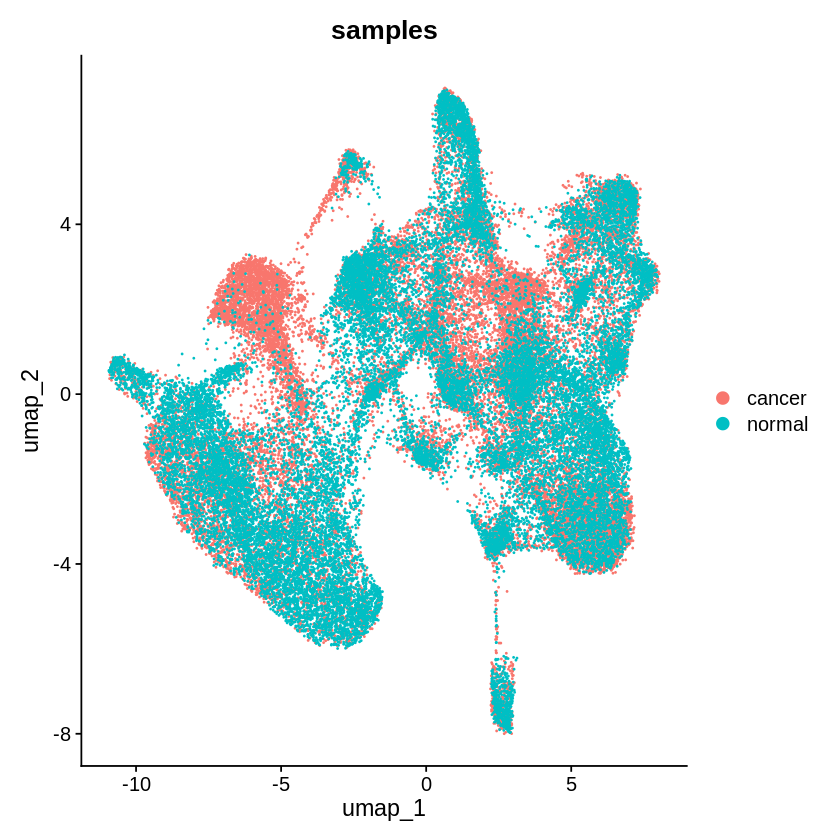

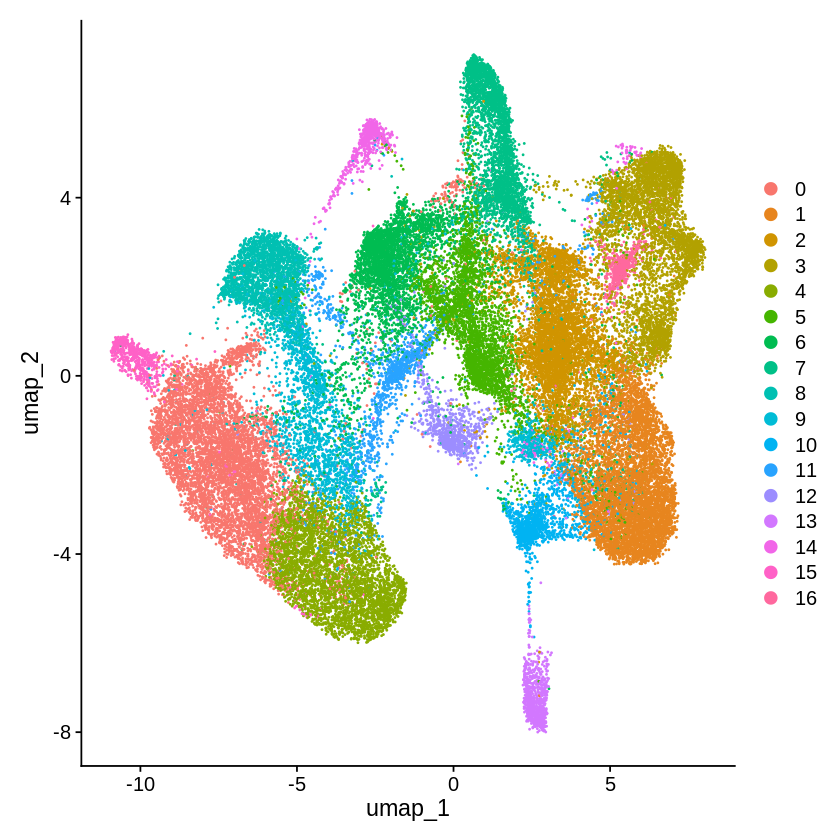

In [ ]:
# plot UMAP after batch correction
DimPlot(merge.obj, group.by = "samples")
DimPlot(merge.obj)

# Section 8. Project results from "sketch" 50k bins to all bins

Since harmony space (batch corrected space), UMAP, and clustering are compuated based on 50k "sketch" bins. We can project these results from 50k bins to ALL bins.

The below 2 steps are to project results from "sketch" bins to all bins. These steps can take long time. We have prepared their results.

**For in-person events, we will skip these two steps and instead directly load the pre-generated results for them.**

In [ ]:
############### SKIP these steps for in-person events ###################

# proeject harmony results from 50k bins (sketch) to all bins (RNA)
# after projection, harmony space for all cells is generated as harmony.full
# runtime: 46s
merge.obj <- ProjectIntegration(object = merge.obj,
                                sketched.assay = "sketch", assay = "RNA",
                                reduction = "harmony")



# project batch corrected clustering results from 50k bins to all bins ("cluster_full")
# project batch corrected UMAP results from 50k bins to all bins ("full.umap")
# runtime: 8mins
merge.obj <- ProjectData(
  object = merge.obj,
  assay = "RNA",
  full.reduction = "harmony.full",
  sketched.assay = "sketch",
  sketched.reduction = "harmony.full",
  umap.model = "umap",
  dims = 1:30,
  refdata = list(cluster_full = "seurat_clusters")
)

In [ ]:
##################### load pre-generated result for in-person events ###########################
merge.obj <- readRDS("/content/visium_hd_multisample/backup/HD_integration_after_ProjectData.rds")

In [ ]:
merge.obj

An object of class Seurat 
36164 features across 789975 samples within 2 assays 
Active assay: sketch (18082 features, 2000 variable features)
 3 layers present: data, counts, scale.data
 1 other assay present: RNA
 5 dimensional reductions calculated: pca, umap, harmony, harmony.full, full.umap

After projecting results from 50k cells to all cells, we can visualize UMAP results for all cells after batch correction.

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



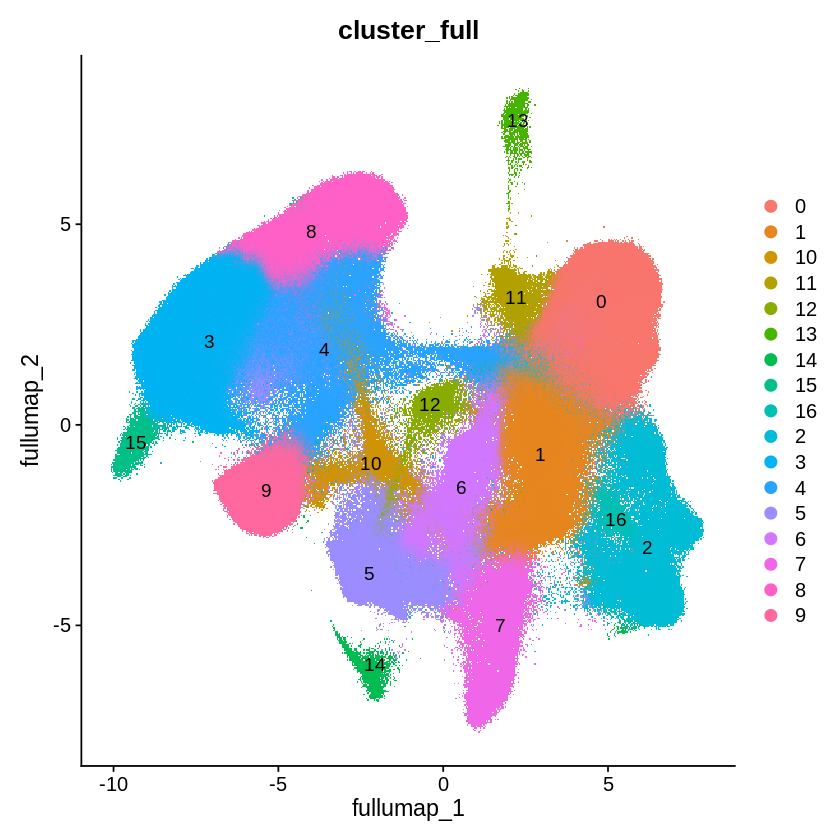

In [ ]:
DimPlot(merge.obj, reduction = "full.umap", group.by = "cluster_full",label = TRUE)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



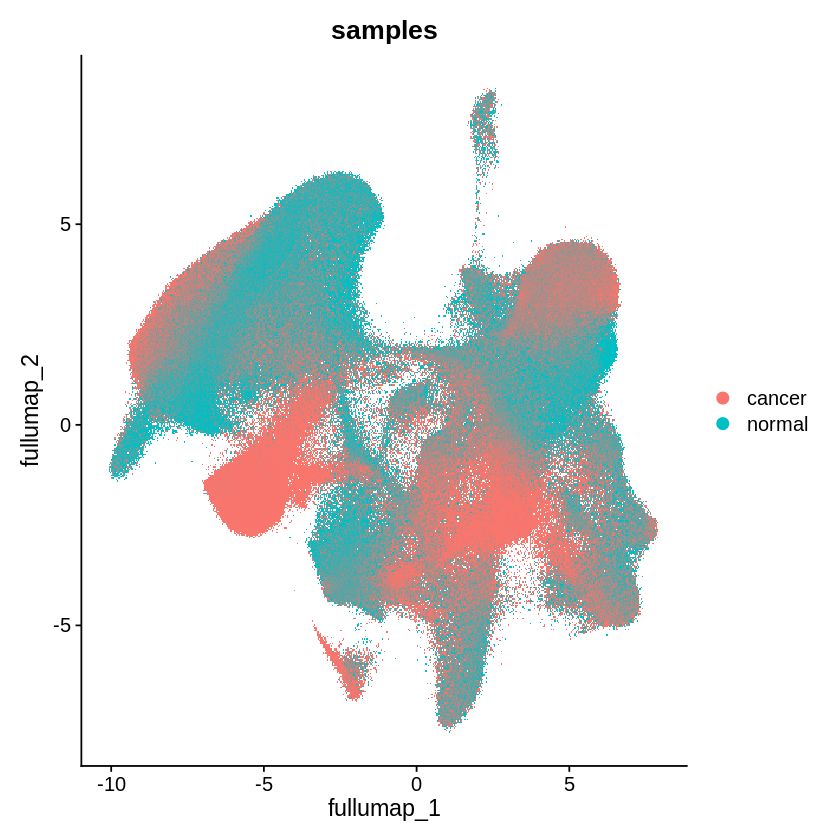

In [ ]:
DimPlot(merge.obj, reduction = "full.umap", group.by = "samples")

# Section 9. Export all bin clustering results in csv and import to Loupe Browser

After batch correction, we can export batch corrected clustering results in csv files for both colon cancer and adjacent normal data separately. We can import each sample's clsutering results (generated by integrative analysis) into its own Loupe Browser file.

In [ ]:
clusters_all <- FetchData(merge.obj, vars = c("cluster_full","samples"))

# since we added suffix in cell IDs in Session 3, here we need to remove suffix, back to original IDs
clusters_all$cell_id <- sapply(strsplit(rownames(clusters_all),"\\."),function(X){return(X[1])})
head(clusters_all)

cluster_full samples cell_id              
s_008um_00602_00290-1.cancer 0            cancer  s_008um_00602_00290-1
s_008um_00789_00234-1.cancer 1            cancer  s_008um_00789_00234-1
s_008um_00728_00006-1.cancer 1            cancer  s_008um_00728_00006-1
s_008um_00526_00291-1.cancer 4            cancer  s_008um_00526_00291-1
s_008um_00681_00396-1.cancer 0            cancer  s_008um_00681_00396-1
s_008um_00078_00444-1.cancer 4            cancer  s_008um_00078_00444-1

In [ ]:
# get clustering results for cancer data
clusters_all_cancer <- clusters_all[(clusters_all$samples == "cancer"),c("cell_id","cluster_full")]
colnames(clusters_all_cancer) <- c("Barcode","Cluster")
write.table(clusters_all_cancer,"integrated_clusters_for_cancer.csv",
            sep=",", col.names=TRUE, row.names=FALSE, quote=FALSE)

In [ ]:
# get clustering results for normal data
clusters_all_normal <- clusters_all[(clusters_all$samples == "normal"),c("cell_id","cluster_full")]
colnames(clusters_all_normal) <- c("Barcode","Cluster")
write.table(clusters_all_normal,"integrated_clusters_for_normal.csv",
            sep=",", col.names=TRUE, row.names=FALSE, quote=FALSE)

Now we can upload clustering results to Loupe Browser file

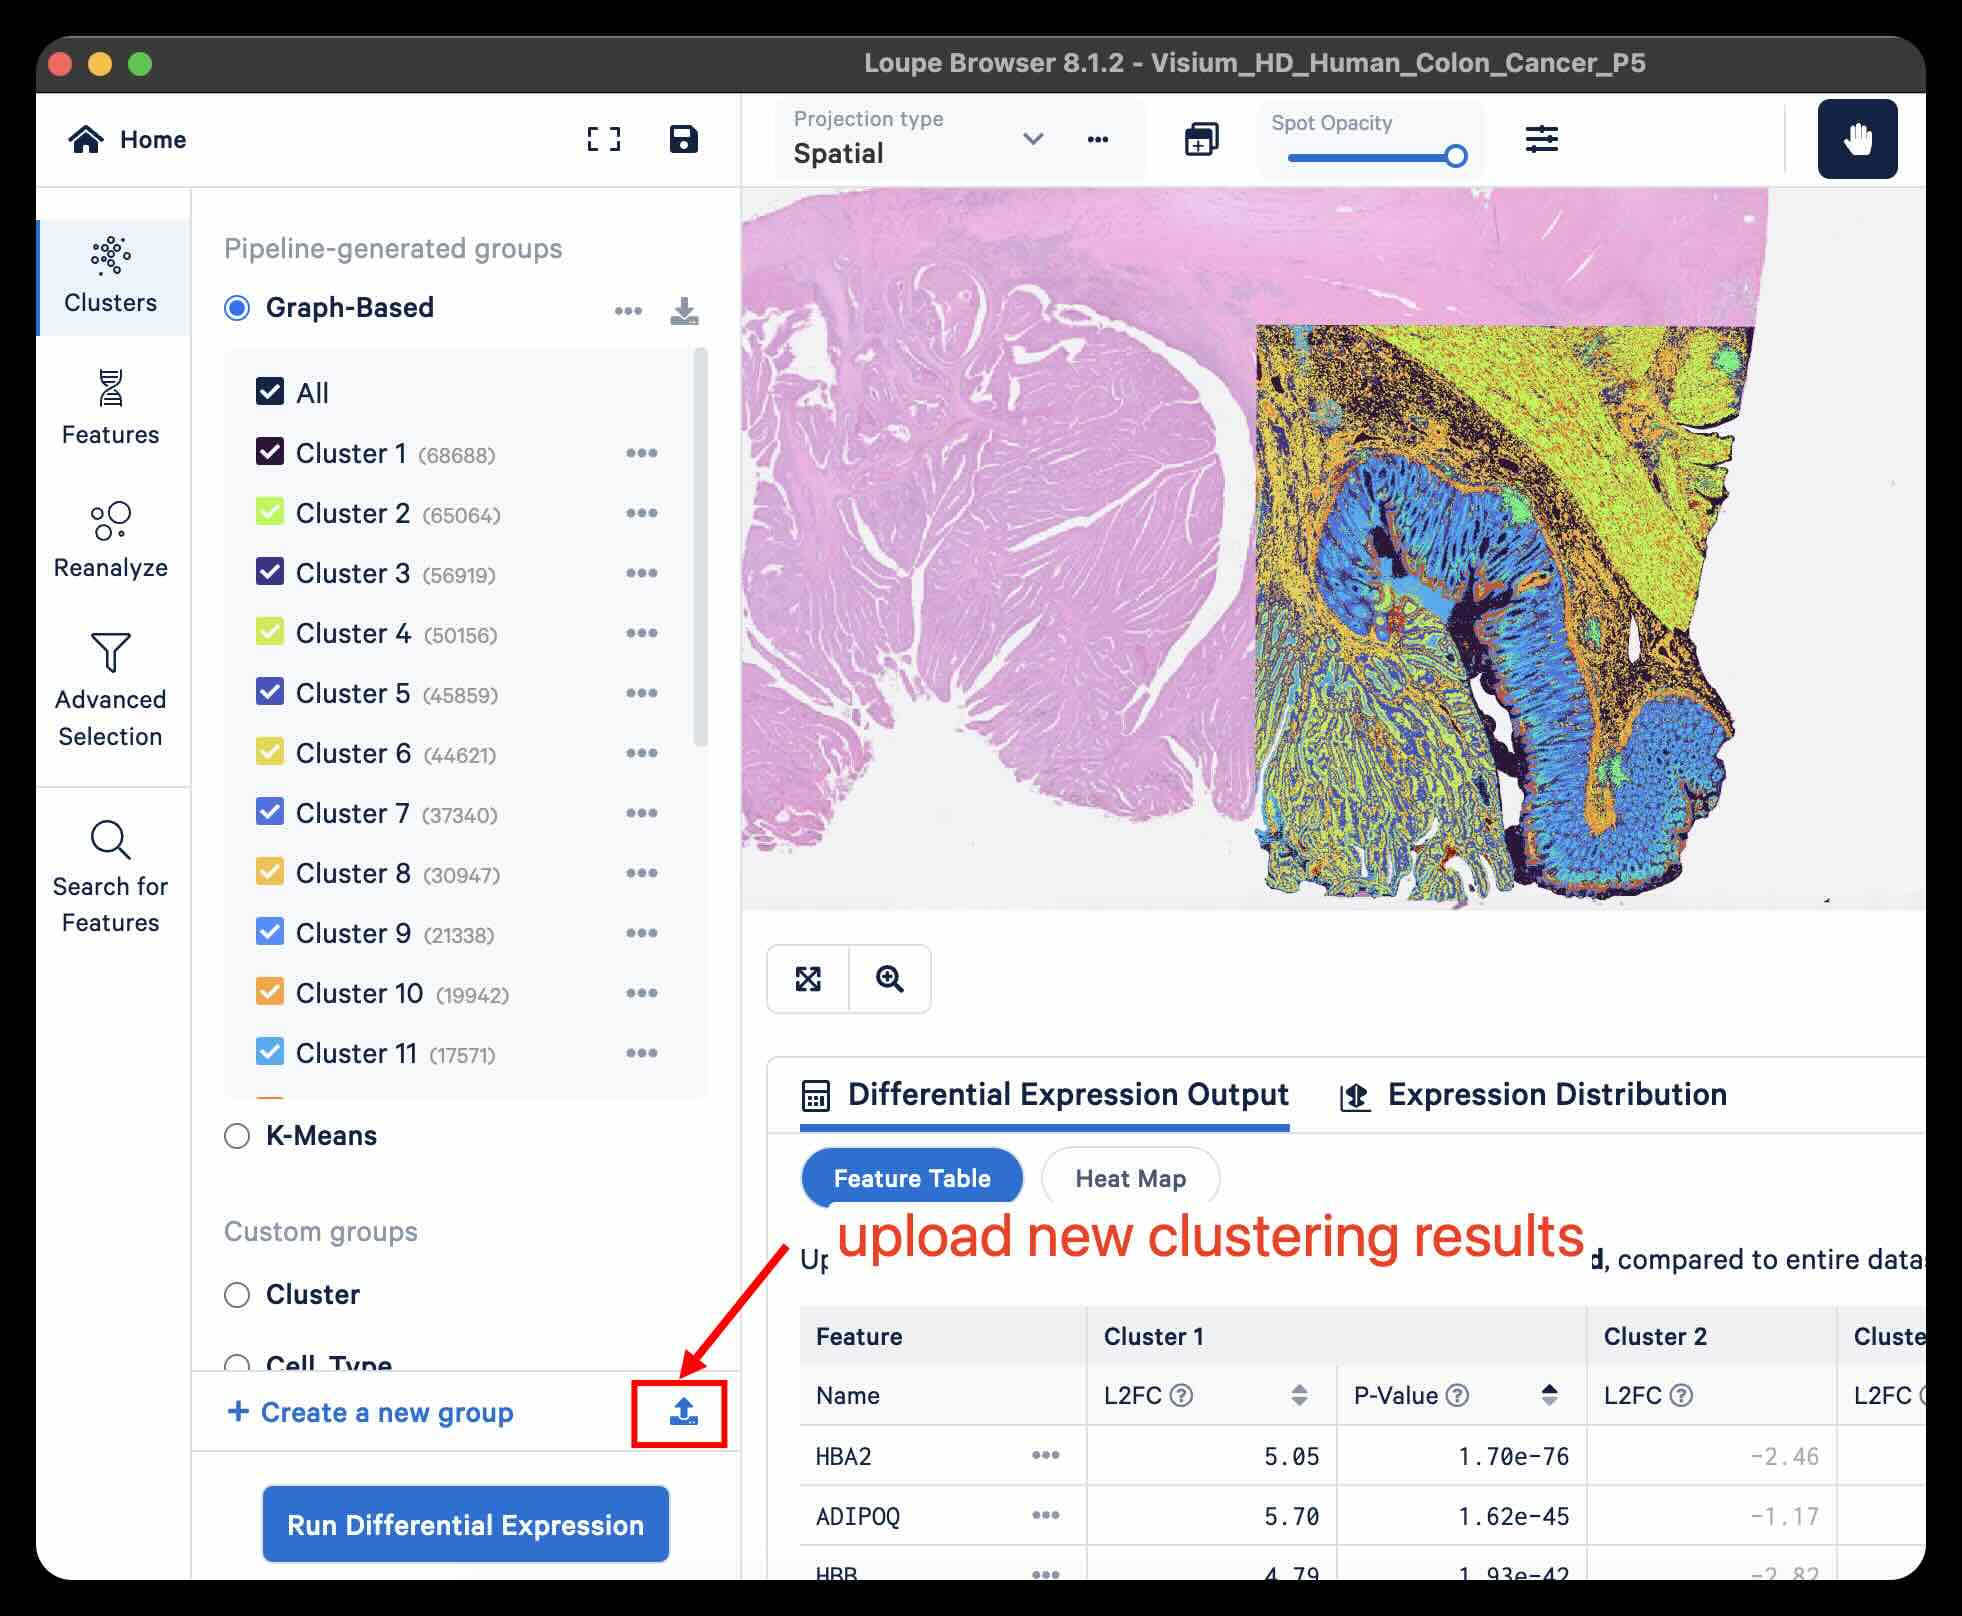

# Section 10. Find cluster marker genes for cell annotation

We can compute marker genes in each cluster and accordingly annotate each cluster

In [ ]:
merge.obj

An object of class Seurat 
36164 features across 789975 samples within 2 assays 
Active assay: sketch (18082 features, 2000 variable features)
 3 layers present: data, counts, scale.data
 1 other assay present: RNA
 5 dimensional reductions calculated: pca, umap, harmony, harmony.full, full.umap

In [ ]:
DefaultAssay(merge.obj) <- "sketch"

# join cancer and normal matrices in sketch (50k cells)
merge.obj[["sketch"]] <- JoinLayers(merge.obj[["sketch"]])

merge.obj

An object of class Seurat 
36164 features across 789975 samples within 2 assays 
Active assay: sketch (18082 features, 2000 variable features)
 3 layers present: data, counts, scale.data
 1 other assay present: RNA
 5 dimensional reductions calculated: pca, umap, harmony, harmony.full, full.umap

 ### **Task 7**

Let's use `FindAllMarkers` function to find marker genes in each cluster. Use `only.pos=TRUE` to call enriched markers.

In [ ]:
# calculate marker genes for each cluster
all.markers <- ADD_YOUR_CODE_HERE

In [ ]:
# save marker gene results in csv
write.table(all.markers,"markers_for_all_clusters_in_sketch.csv", sep=",", col.names = TRUE,
            row.names=FALSE, quote=FALSE)

Here we are sharing one possible way to annotate each cluster.

Step 1. Get marker genes in each cluster.

Step 2. Find cell type that is highly associated with the provided marker genes via third-party tools, such as [Enrichr](https://maayanlab.cloud/Enrichr/).

Step 3. Check cluster in HE image and confirm cell type.

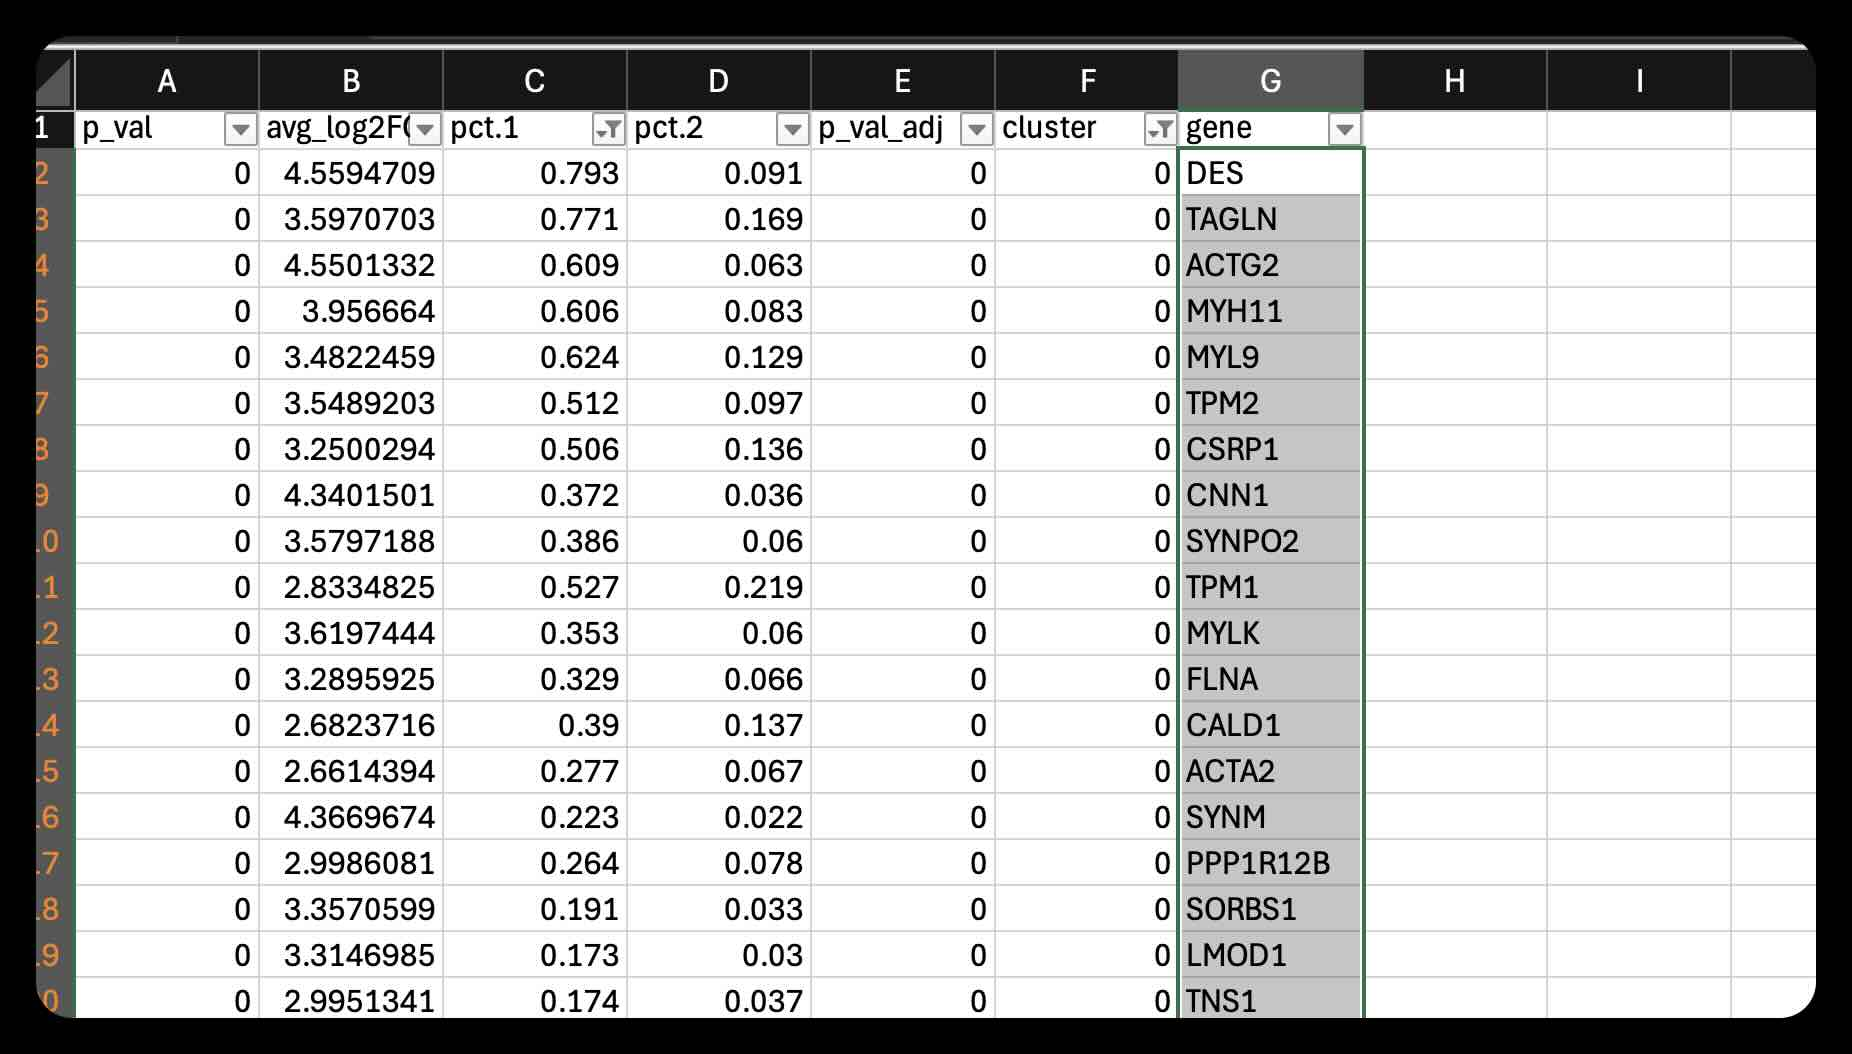

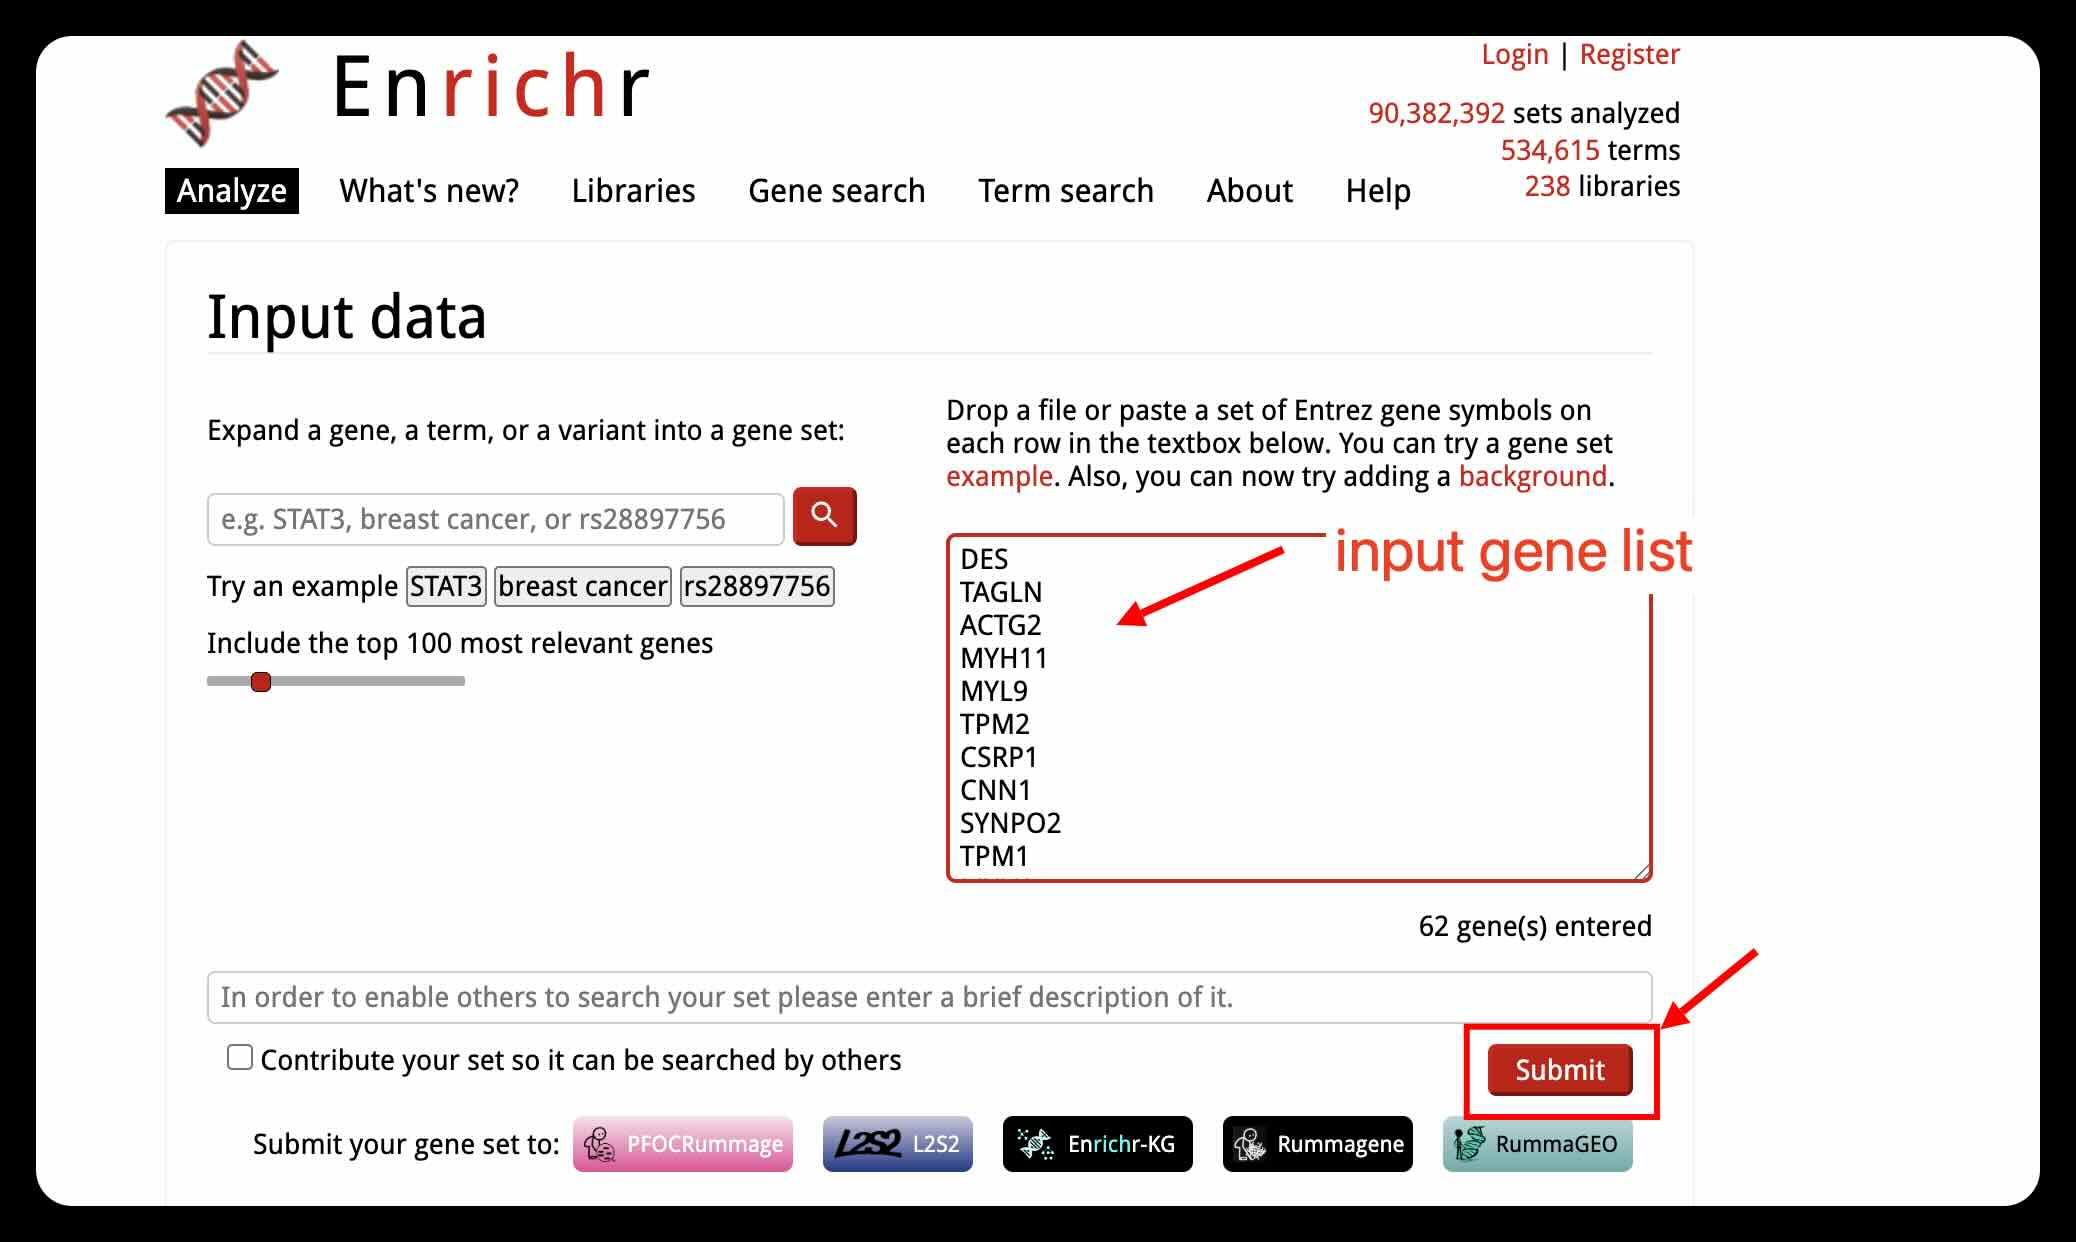

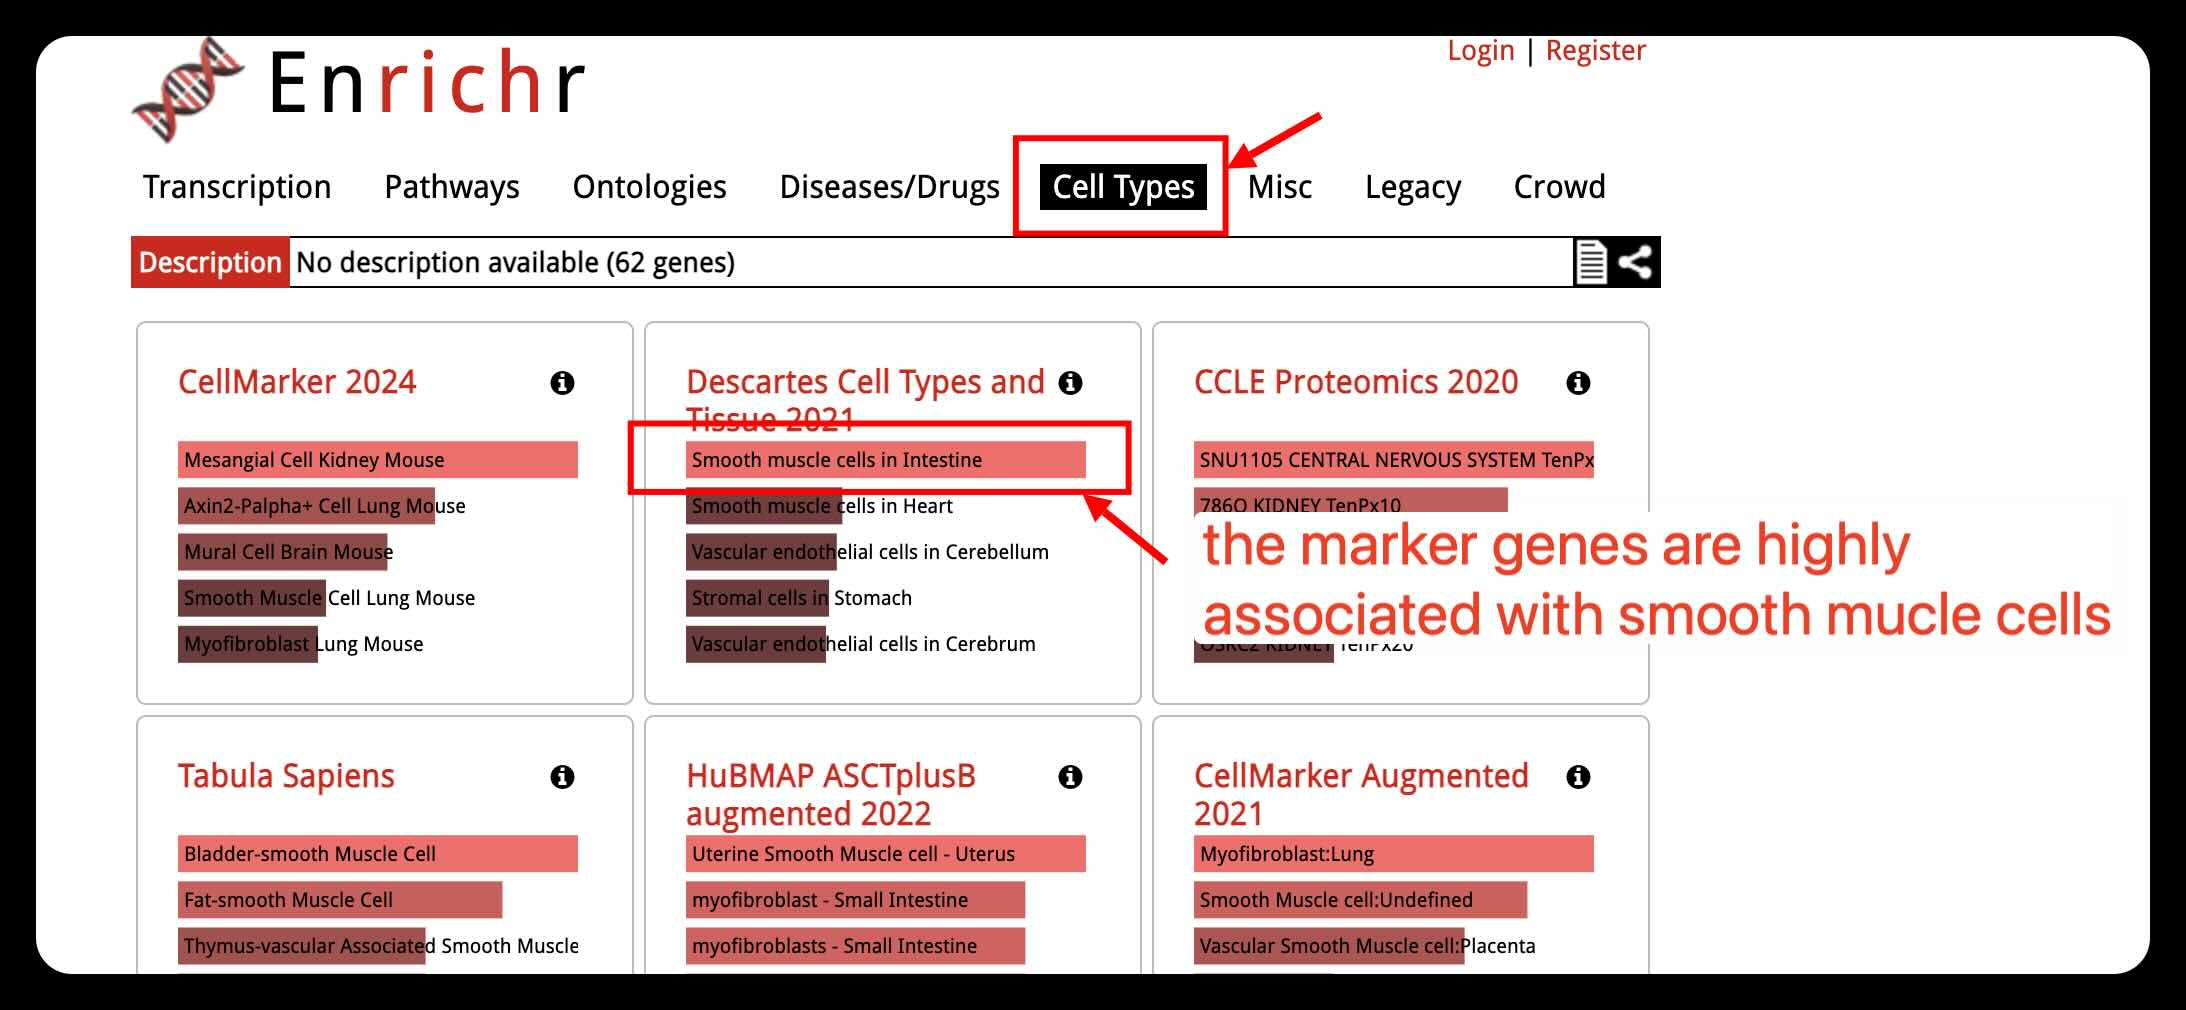

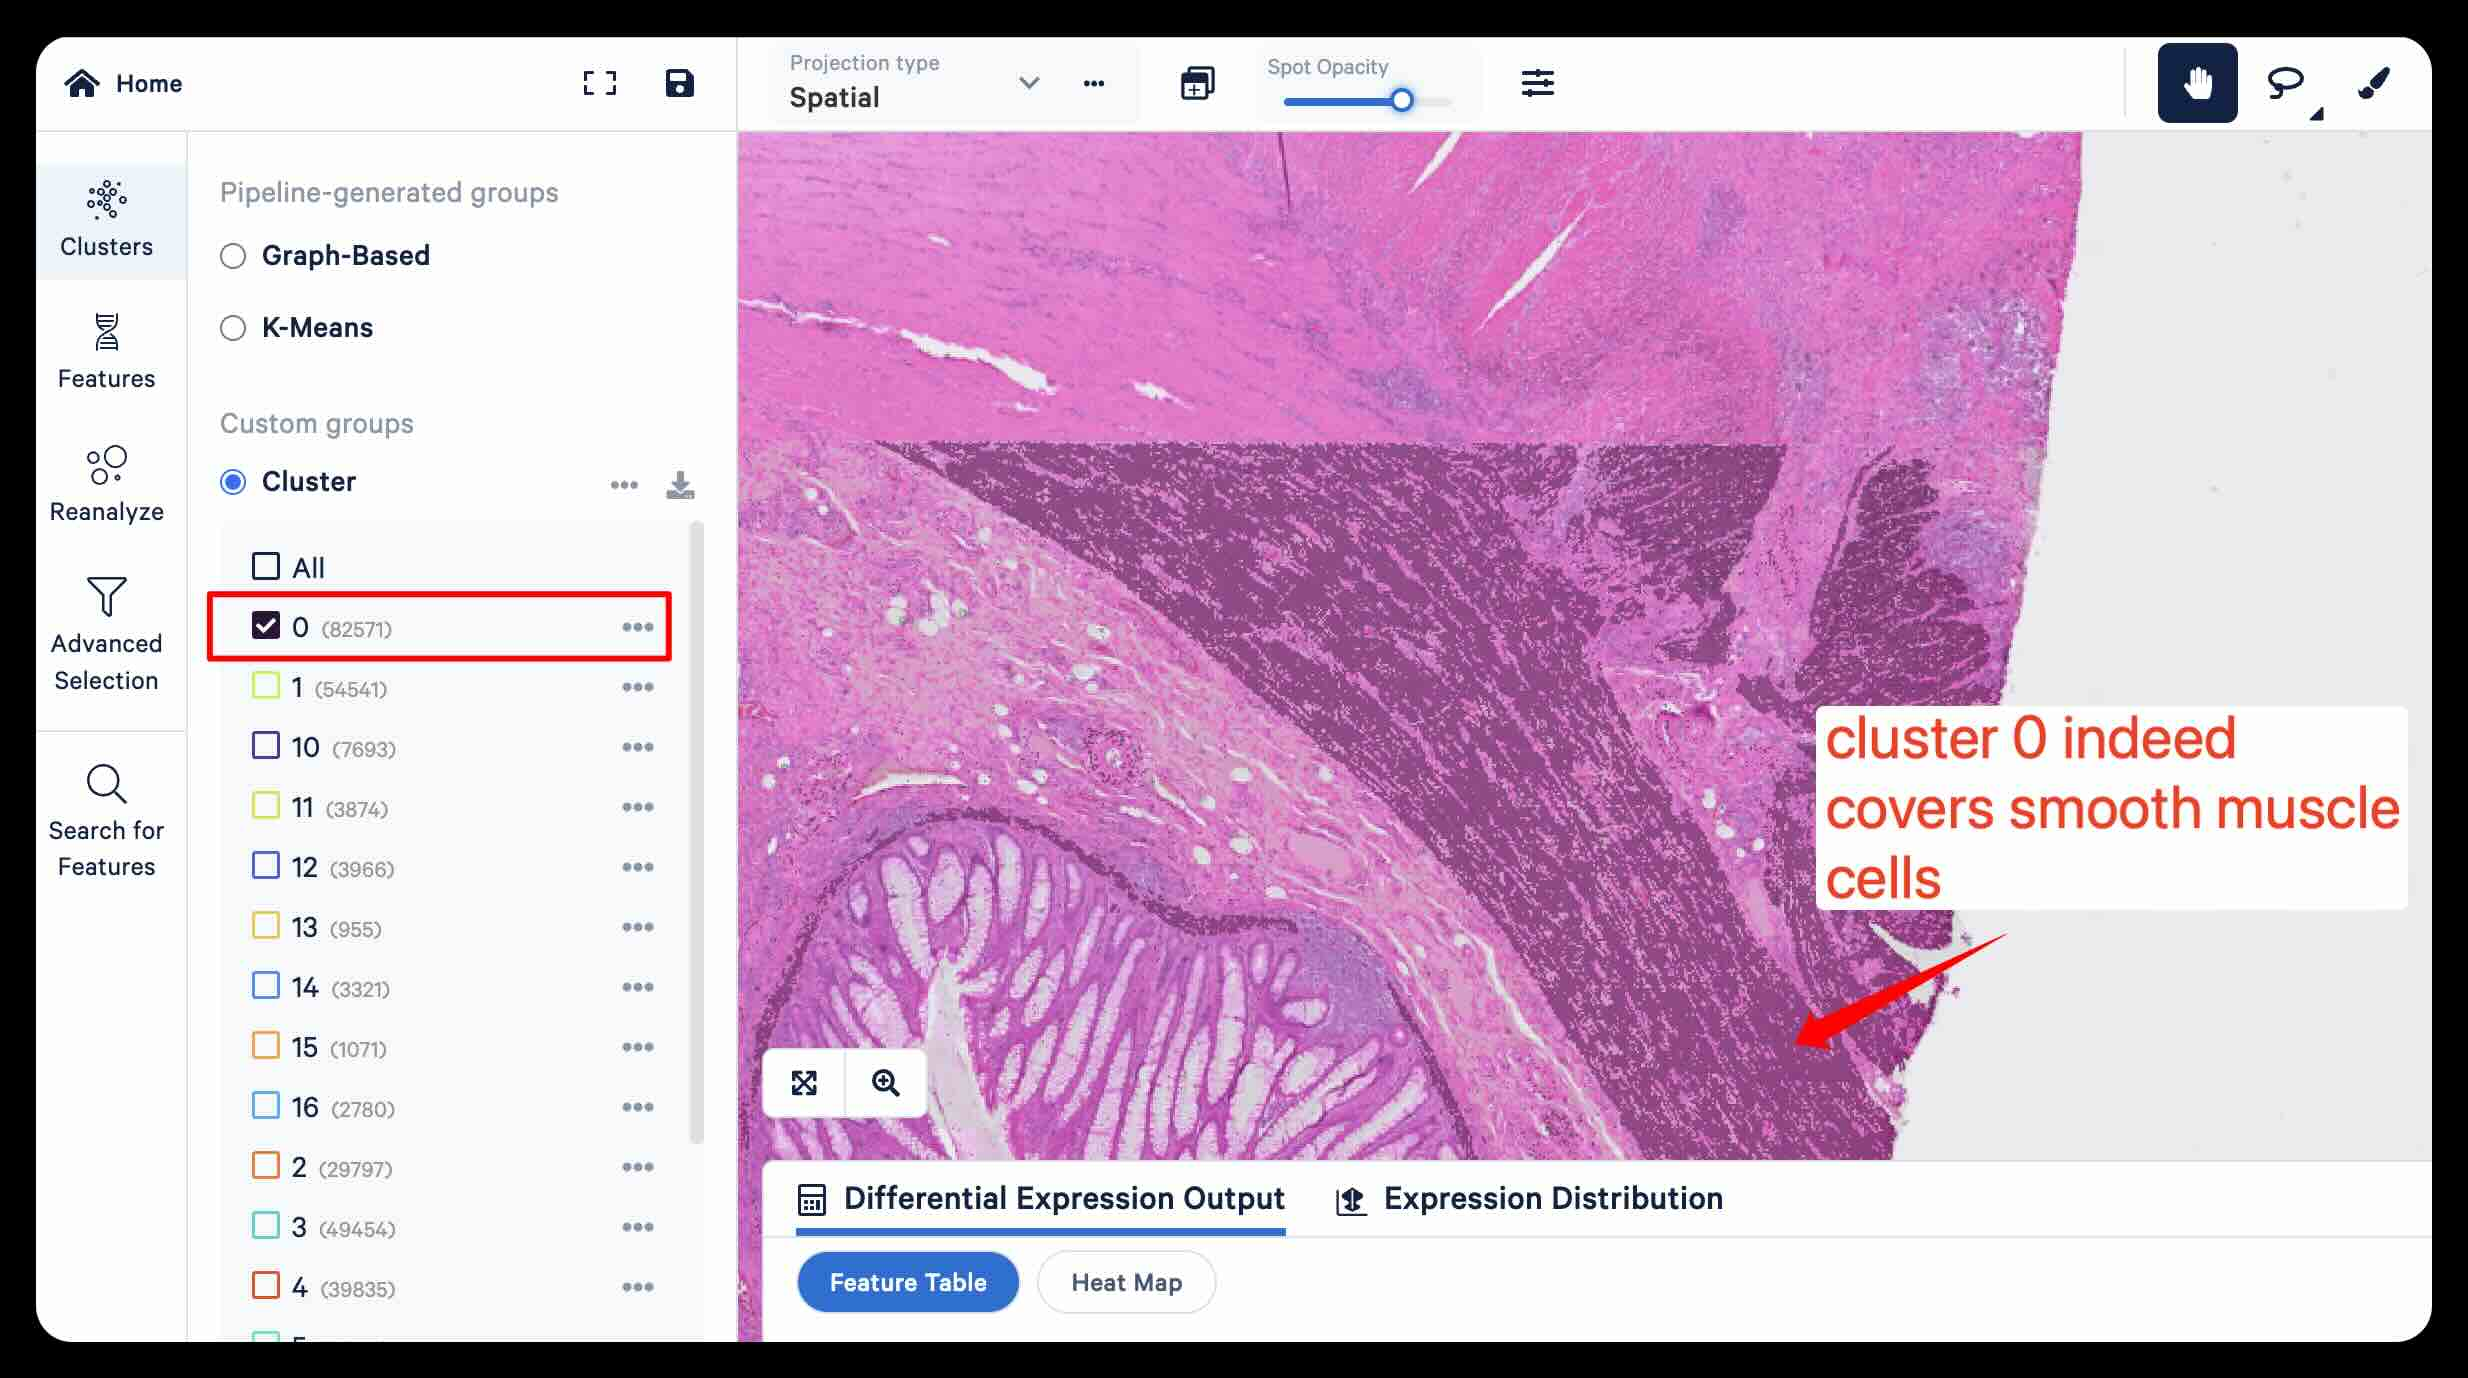

Based on the above approach, we can annotate each cluster

In [ ]:
clusters_all$cell_type <- NA
clusters_all[(clusters_all$cluster_full == 0), "cell_type"] <- "smooth muscle cells"
clusters_all[(clusters_all$cluster_full == 1), "cell_type"] <- "filbroblasts/stromal"
clusters_all[(clusters_all$cluster_full == 2), "cell_type"] <- "endothelial"
clusters_all[(clusters_all$cluster_full == 3), "cell_type"] <- "globlet cells"
clusters_all[(clusters_all$cluster_full == 4), "cell_type"] <- "globlet cells"
clusters_all[(clusters_all$cluster_full == 5), "cell_type"] <- "plasma B"
clusters_all[(clusters_all$cluster_full == 6), "cell_type"] <- "macrophages"
clusters_all[(clusters_all$cluster_full == 7), "cell_type"] <- "B cells"
clusters_all[(clusters_all$cluster_full == 8), "cell_type"] <- "globlet cells"
clusters_all[(clusters_all$cluster_full == 9), "cell_type"] <- "tumor"
clusters_all[(clusters_all$cluster_full == 10), "cell_type"] <- "filbroblasts/stromal"
clusters_all[(clusters_all$cluster_full == 11), "cell_type"] <- "nerve"
clusters_all[(clusters_all$cluster_full == 12), "cell_type"] <- "mast cells"
clusters_all[(clusters_all$cluster_full == 13), "cell_type"] <- "ENS neuron"
clusters_all[(clusters_all$cluster_full == 14), "cell_type"] <- "neutrophils"
clusters_all[(clusters_all$cluster_full == 15), "cell_type"] <- "enteroendocrine"
clusters_all[(clusters_all$cluster_full == 16), "cell_type"] <- "endothelial"

In [ ]:
head(clusters_all)

cluster_full samples cell_id              
s_008um_00602_00290-1.cancer 0            cancer  s_008um_00602_00290-1
s_008um_00789_00234-1.cancer 1            cancer  s_008um_00789_00234-1
s_008um_00728_00006-1.cancer 1            cancer  s_008um_00728_00006-1
s_008um_00526_00291-1.cancer 4            cancer  s_008um_00526_00291-1
s_008um_00681_00396-1.cancer 0            cancer  s_008um_00681_00396-1
s_008um_00078_00444-1.cancer 4            cancer  s_008um_00078_00444-1
                             cell_type           
s_008um_00602_00290-1.cancer smooth muscle cells 
s_008um_00789_00234-1.cancer filbroblasts/stromal
s_008um_00728_00006-1.cancer filbroblasts/stromal
s_008um_00526_00291-1.cancer globlet cells       
s_008um_00681_00396-1.cancer smooth muscle cells 
s_008um_00078_00444-1.cancer globlet cells

Export cell annotation results in csv and import into Loupe Browser file.

In [ ]:
clusters_all_cancer <- clusters_all[(clusters_all$samples == "cancer"),c("cell_id","cell_type")]
colnames(clusters_all_cancer) <- c("Barcode","Cell_Type")
write.table(clusters_all_cancer,"cell_annotation_for_cancer.csv",
            sep=",", col.names=TRUE, row.names=FALSE, quote=FALSE)

In [ ]:
clusters_all_normal <- clusters_all[(clusters_all$samples == "normal"),c("cell_id","cell_type")]
colnames(clusters_all_normal) <- c("Barcode","Cell_Type")
write.table(clusters_all_normal,"cell_annotation_for_normal.csv",
            sep=",", col.names=TRUE, row.names=FALSE, quote=FALSE)

Keep cell annotation results in Seurat data.

In [ ]:
clusters_all <- clusters_all[colnames(merge.obj),]
merge.obj$cell_type <- clusters_all$cell_type

Plot cell annotation results in UMAP

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



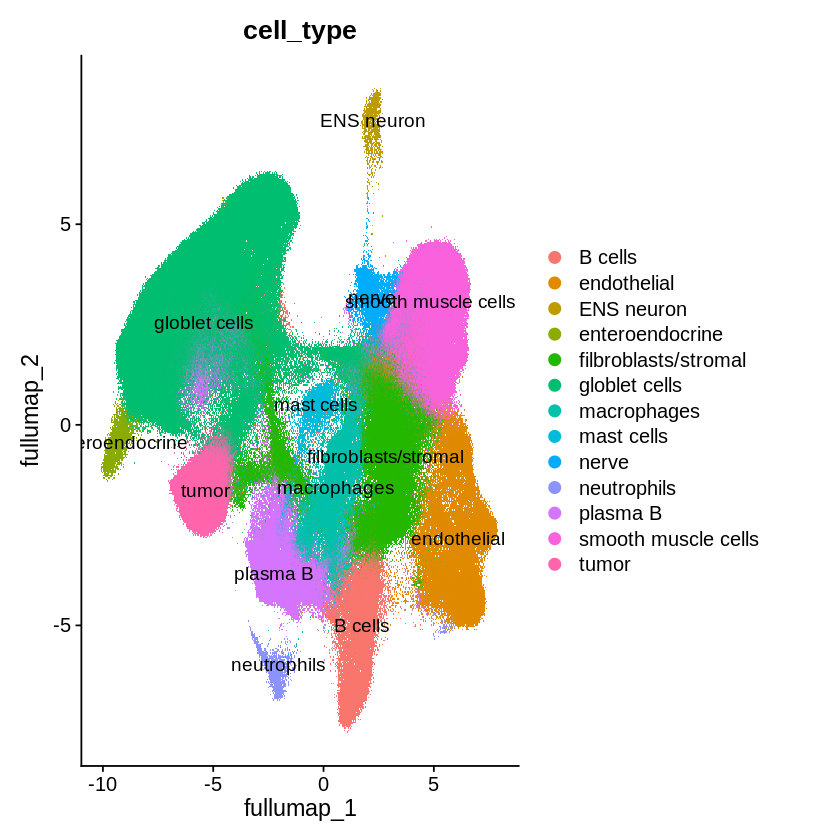

In [ ]:
DimPlot(merge.obj, reduction = "full.umap", group.by = "cell_type", label = TRUE)

# Section 11. Save Seurat object

We can use `saveRDS` to save this Seurat (with sketch) in a rds file locally. Please be noted that since this Seurat object also links to on-disk data (in the folders `colon_cancer_matrix` and `colon_normal_matrix`). Hence, the complete saved data: saved Seurat object rds file + all on-disk data folders.

In [ ]:
saveRDS(merge.obj,"integrated_HD_Seurat_sketch.rds")

In this demo case, we need to keep `integrated_HD_Seurat_sketch.rds` + `colon_cancer_matrix/` + `colon_normal_matrix/` as a whole

Next time when we re-load this integrated Seurat object, we just need to use `readRDS` to read rds file. Of course, on-disk data folders also need to be there (`colon_cancer_matrix` and `colon_normal_matrix`).

In [ ]:
# reload integrated Seurat object from rds
merge.obj <- readRDS("./integrated_HD_Seurat_sketch.rds")

# Section 12. Subset Seurat for fibroblasts

Below we subset fibroblasts only and compare gene expression in fibroblasts between colon cancer tissue and adjacent normal tissiue. Below demonstration is more for explorative purpose to compare fibroblast between two tissues. The p-values obtained from this analysis should be interpreted with caution, because these tests treat each bin as an independent replicate, which could cause false positives.

**A more robust statistic test for differential expression genes (DEG) between conditions requires biological replicates (at least 3 biological replicates per condition are recommended) and pseudo-bulk DEG analysis approach can be used for this analysis.** See more documentations below:

*   [Differential Gene Expression Analysis in scRNA-seq Data between Conditions with Biological Replicates](https://www.10xgenomics.com/analysis-guides/differential-gene-expression-analysis-in-scrna-seq-data-between-conditions-with-biological-replicates)
*   [Use Seurat for pseudo-bulk DE analysis](https://satijalab.org/seurat/articles/de_vignette#perform-de-analysis-after-pseudobulking)


In [ ]:
# get all barcode IDs for fibroblasts
fibro_cells <- names(merge.obj$cluster_full[(merge.obj$cell_type == "filbroblasts/stromal")])

### **Task 8**

Let's subset filbroblast cells from whole Seurat data `merge.obj` using `subset` function.
-  cells: fibroblast cell IDs

In [ ]:
# based on fibroblast cell IDs, subset Seurat object
fibro.obj <- ADD_YOUR_CODE_HERE

In [ ]:
fibro.obj

An object of class Seurat 
36164 features across 88711 samples within 2 assays 
Active assay: sketch (18082 features, 2000 variable features)
 3 layers present: data, counts, scale.data
 1 other assay present: RNA
 5 dimensional reductions calculated: pca, umap, harmony, harmony.full, full.umap

Re-do analyses: Find variable genes, data scaling, PCA, harmony correction (on PCA), and UMAP projection on fibroblast cells only.

There are only 89k fibroblasts, which is not too large to do analysis on all cells (`RNA` assay).

The following steps can take quite long time. **For in-person events, we will skip them and directly load pre-generated result.**

In [ ]:
################### SKIP these steps for in-person events ###################

DefaultAssay(fibro.obj) <- "RNA"
fibro.obj <- FindVariableFeatures(fibro.obj, verbose = FALSE)
fibro.obj <- ScaleData(fibro.obj, verbose = FALSE)
fibro.obj <- RunPCA(fibro.obj, verbose = FALSE)


# batch correction using harmony
# correcting PCA
# corrected space is named as harmony.full
fibro.obj <- IntegrateLayers(fibro.obj, method = HarmonyIntegration,
                             orig = "pca", new.reduction = "harmony.full",
                             dims = 1:30)


# run UMAP on corrected space (harmony.full)
fibro.obj <- RunUMAP(fibro.obj, reduction = "harmony.full", dims = 1:30,
                     reduction.name = "umap.full",
                     reduction.key = "UMAP_full_", verbose = FALSE)

In [ ]:
##################### load pre-generated result in for in-person events ###########################

fibro.obj <- readRDS("/content/visium_hd_multisample/backup/fibroblast_integrated_HD_seurat.rds")

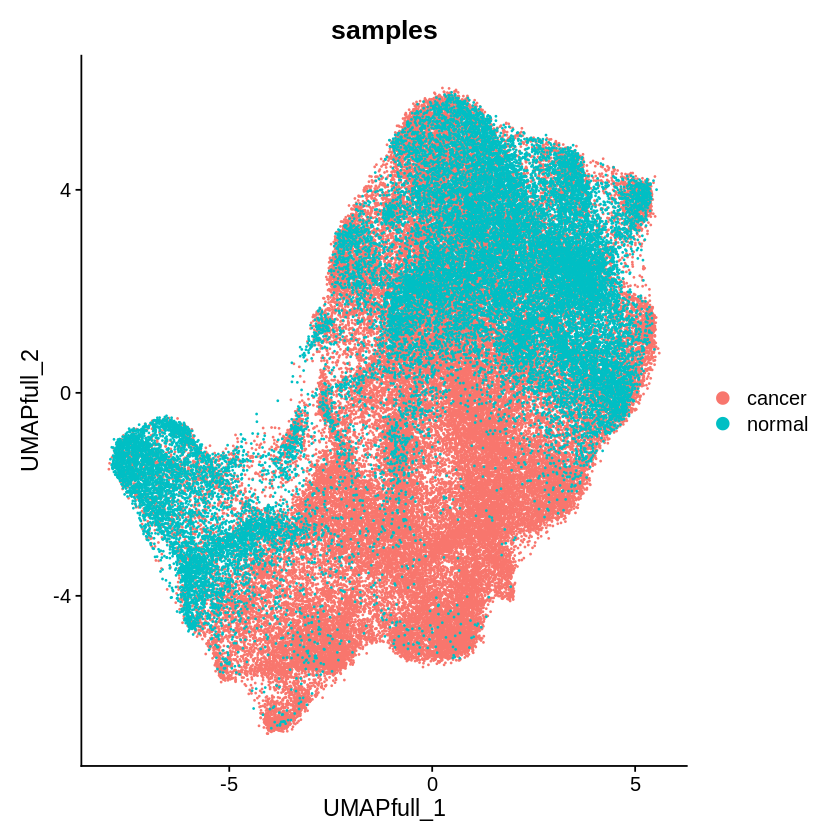

In [ ]:
options(repr.plot.width=7, repr.plot.height=7)
DimPlot(fibro.obj, reduction = "umap.full", group.by = "samples")

In [ ]:
Idents(object = fibro.obj) <- "samples"
fibro.obj[["RNA"]] <- JoinLayers(fibro.obj[["RNA"]])
fibro.marker <-  FindMarkers(fibro.obj, ident.1 = "cancer", ident.2 = "normal")

Based on the DEG results, many collagen related genes are significantly higher expressed in colon cancer tissue, such as COL1A1, COL3A1, and COL1A2.

In [ ]:
# save DEG results in csv
fibro.marker$gene <- rownames(fibro.marker)
write.table(fibro.marker,"Fibroblasts_DGE.csv", sep=",", col.names = TRUE,
            row.names=FALSE, quote=FALSE)

Warning message:
“The `slot` argument of `FetchData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
This message is displayed once every 8 hours.


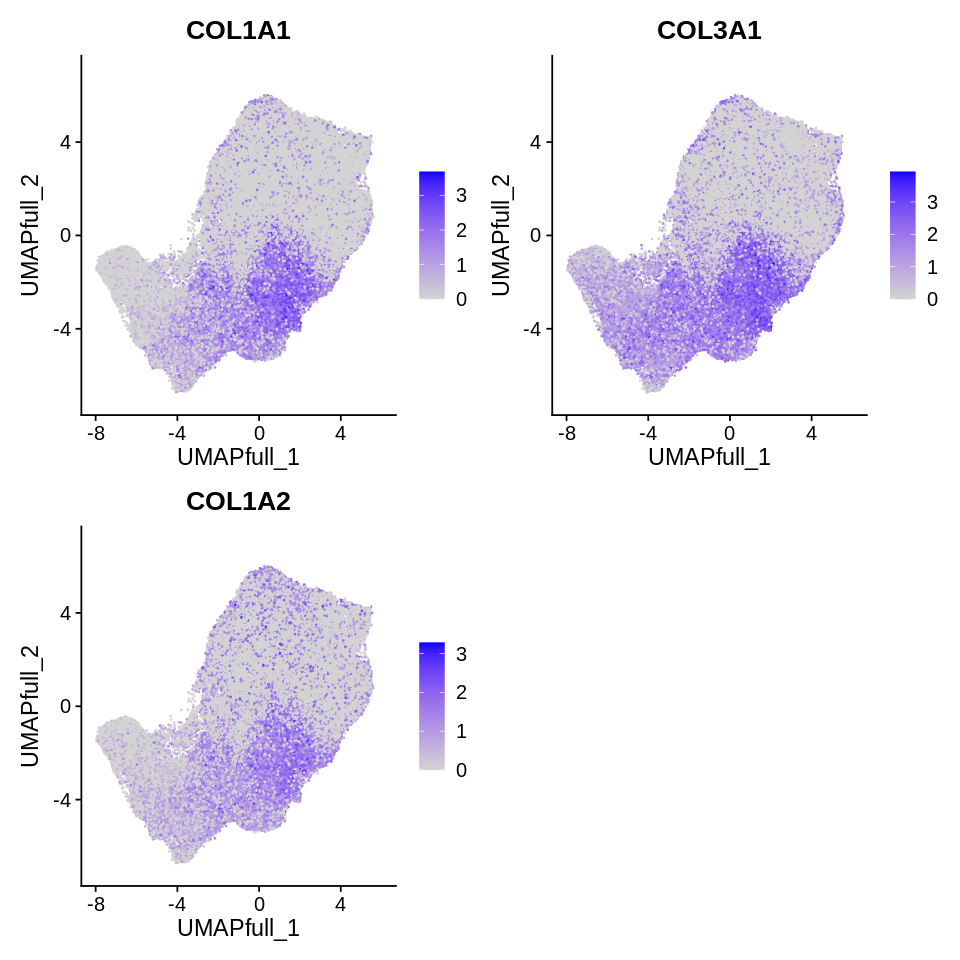

In [ ]:
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(fibro.obj, features = c("COL1A1","COL3A1","COL1A2"),
               reduction = "umap.full",ncol=2)

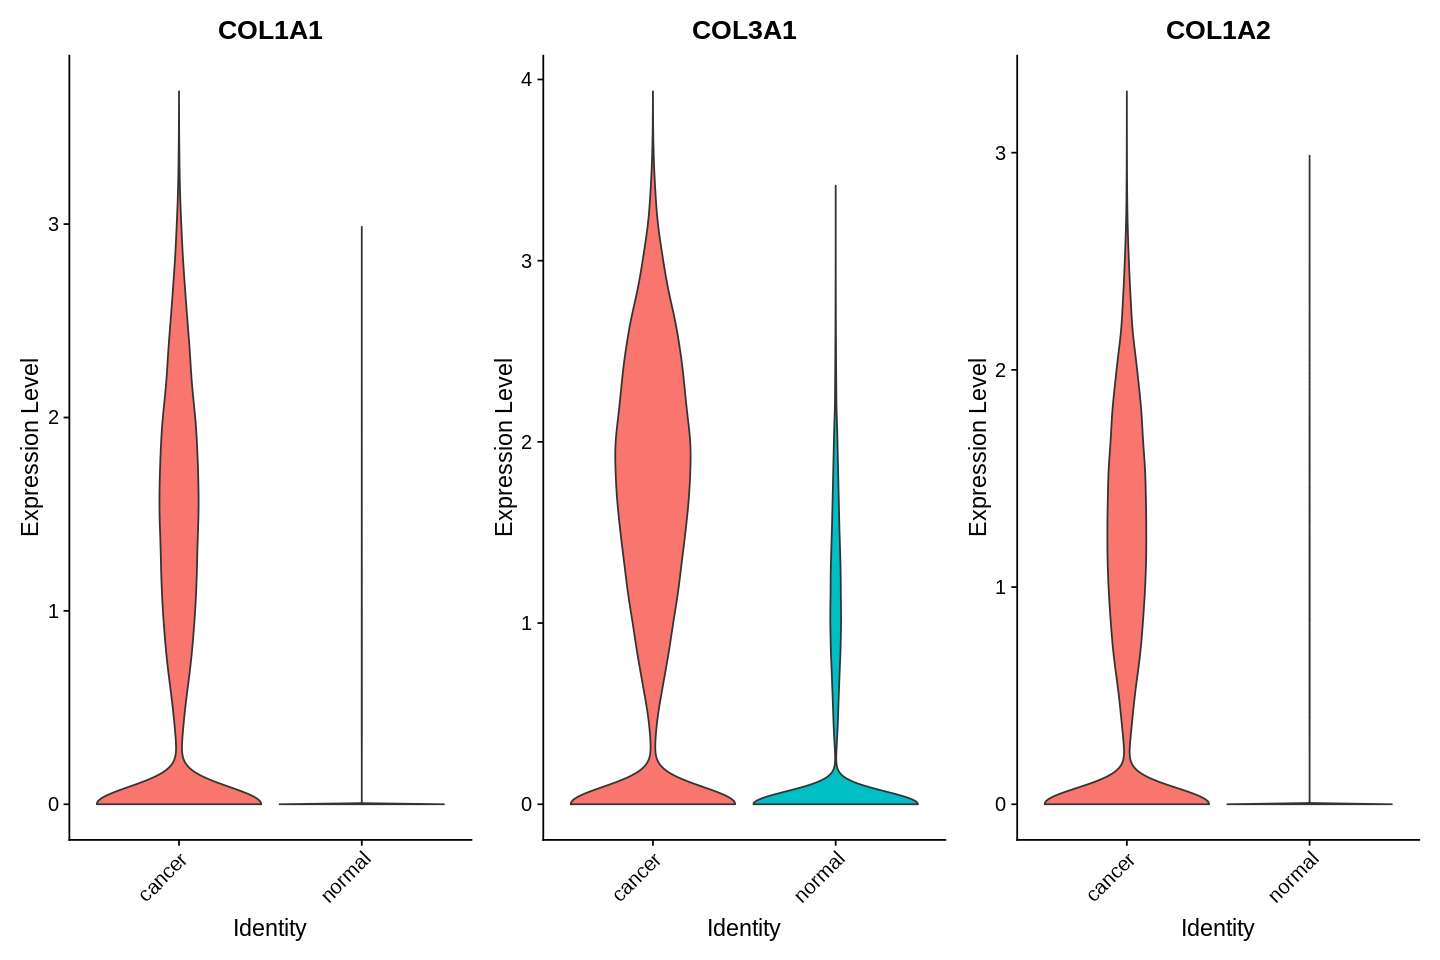

In [ ]:
options(repr.plot.width=12, repr.plot.height=8)
VlnPlot(fibro.obj, c("COL1A1","COL3A1","COL1A2"), group.by = "samples", pt.size=0)

When visualizing expression of genes COL1A1, COL3A1, and COL1A2 spatially in colon cancer and adjacent normal tissues (see Loupe Browser screenshots below - using COL1A1 as an example). Indeed, these genes highly expressed in colon cancer tissue. Interestingly, when only looking into colon cancer data, fibroblasts nearer to tumor areas have higher expression of these genes compared to fibroblasts further away from tumor areas. Previous studies suggest increased expression of collagen related genes in colon cancer, associated with poor prognosis ([Jin, et al., 2022](https://www.aging-us.com/article/204261/text), [Zhang, et al., 2018](https://www.spandidos-publications.com/10.3892/mmr.2018.8533), [Wang, et al., 2016](https://www.oncotarget.com/article/6815/text/)).

- Colon cancer tissue

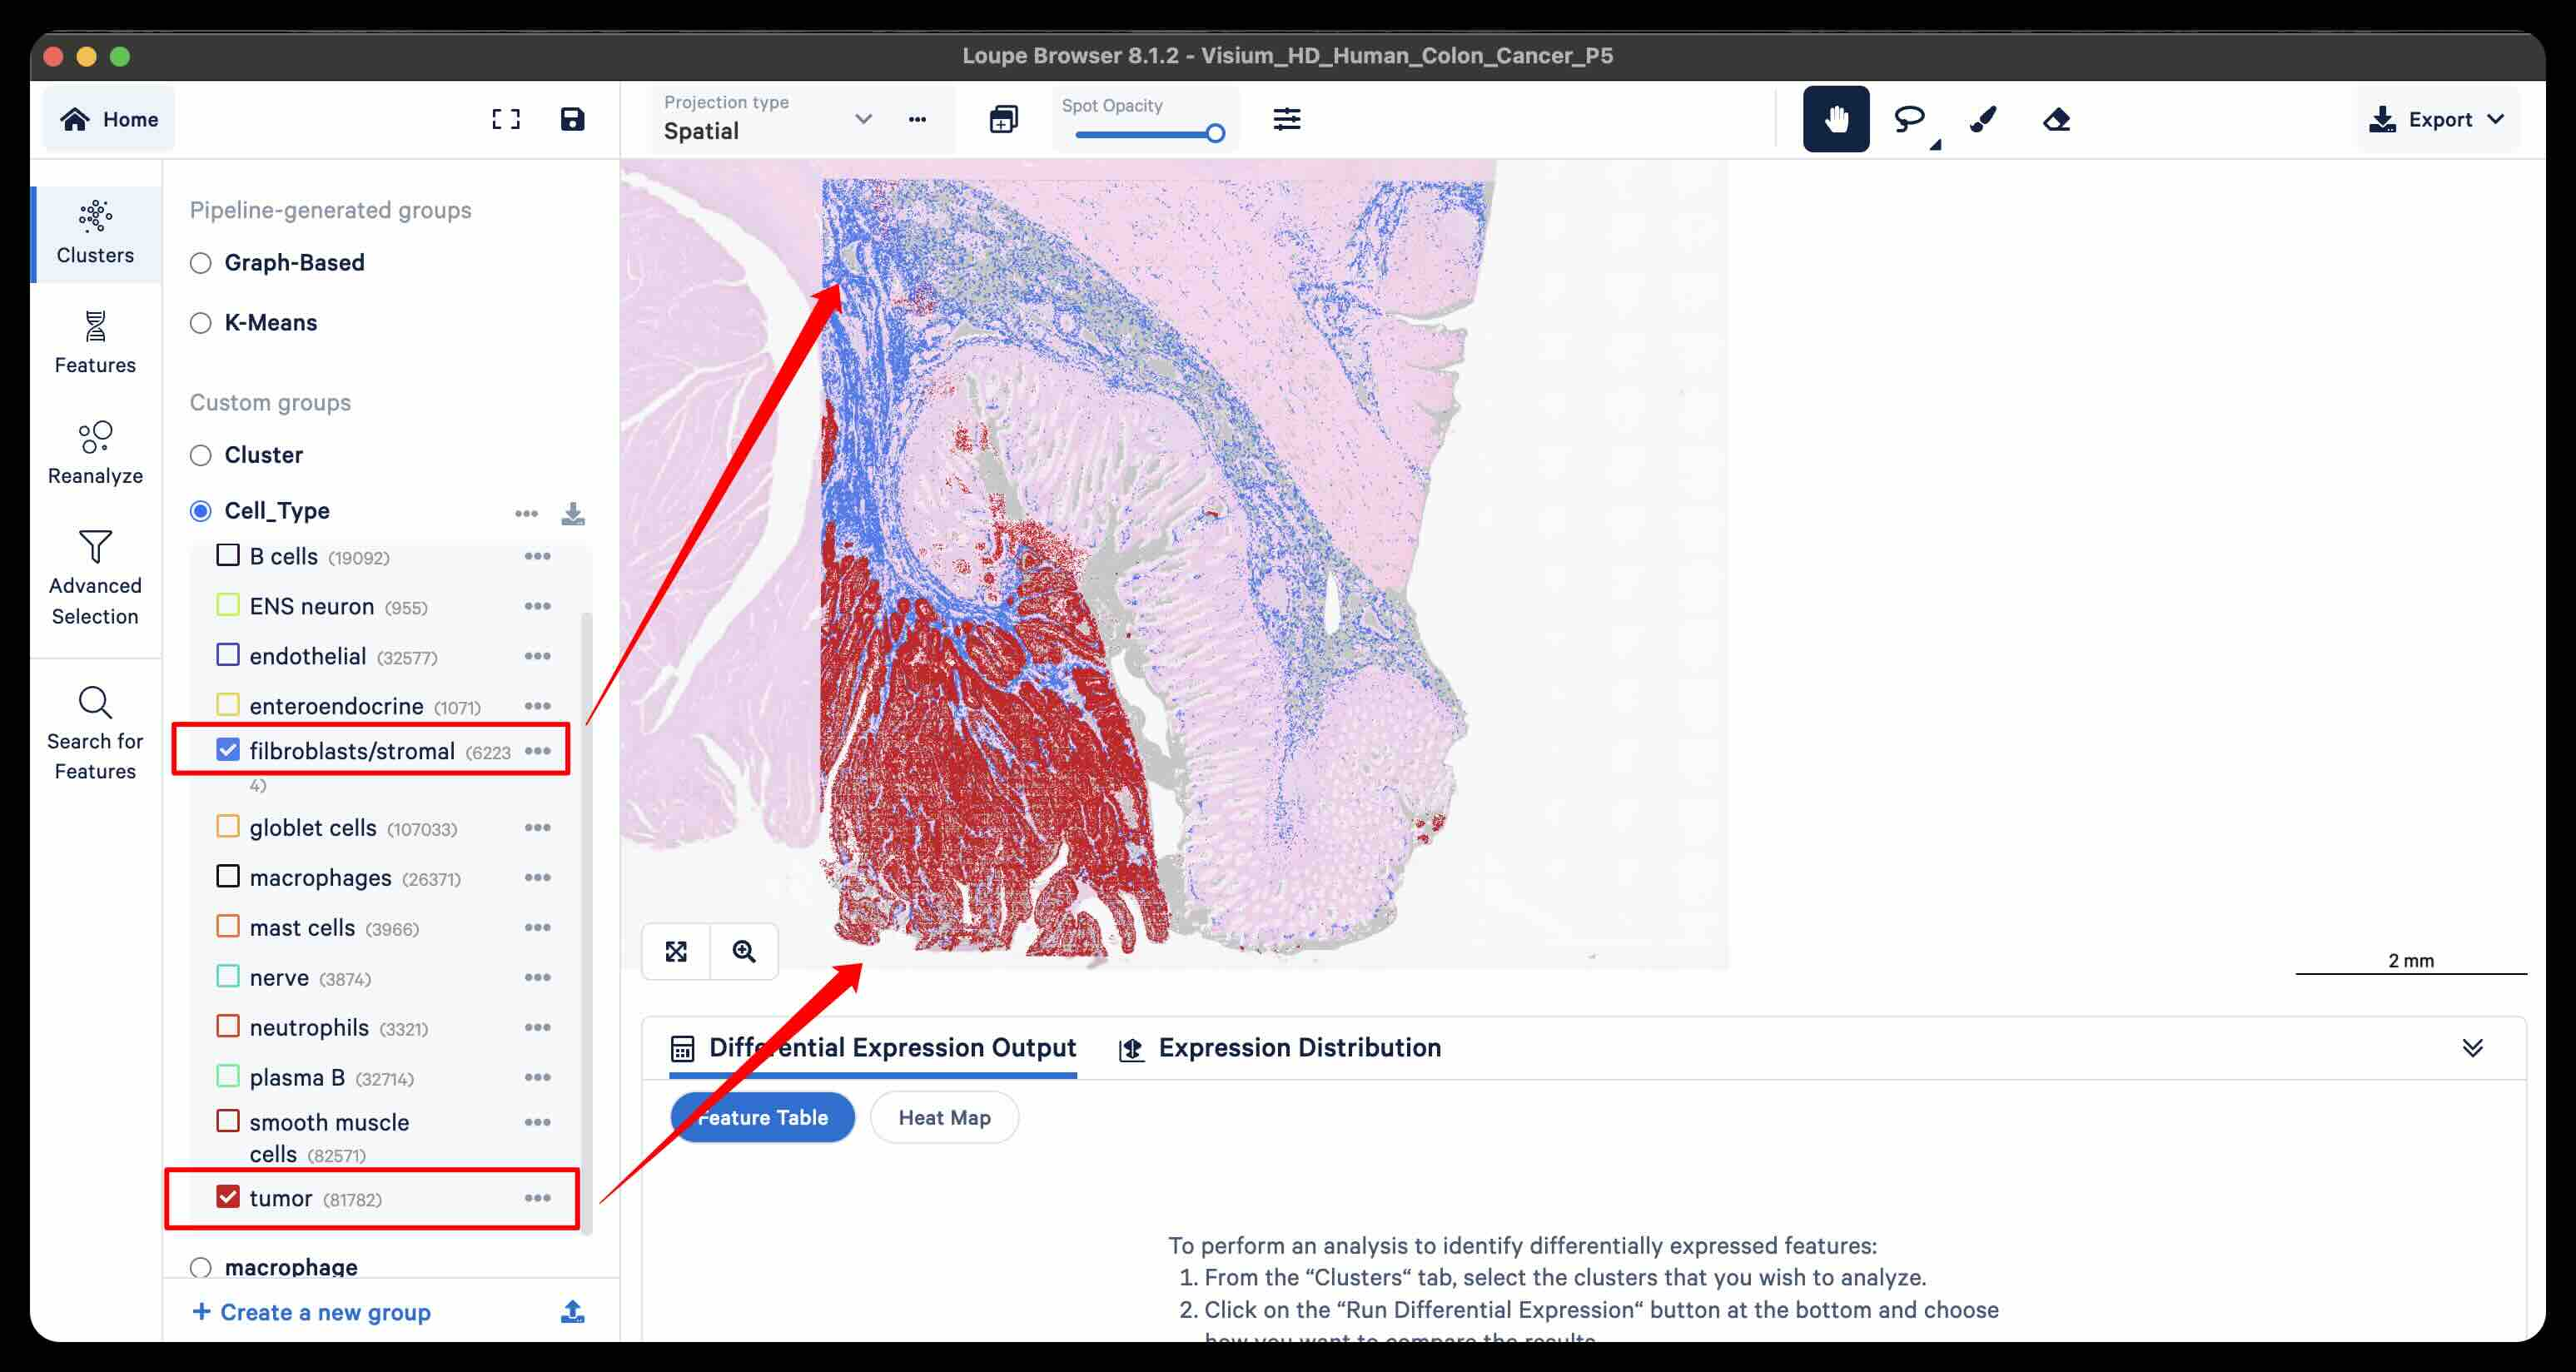

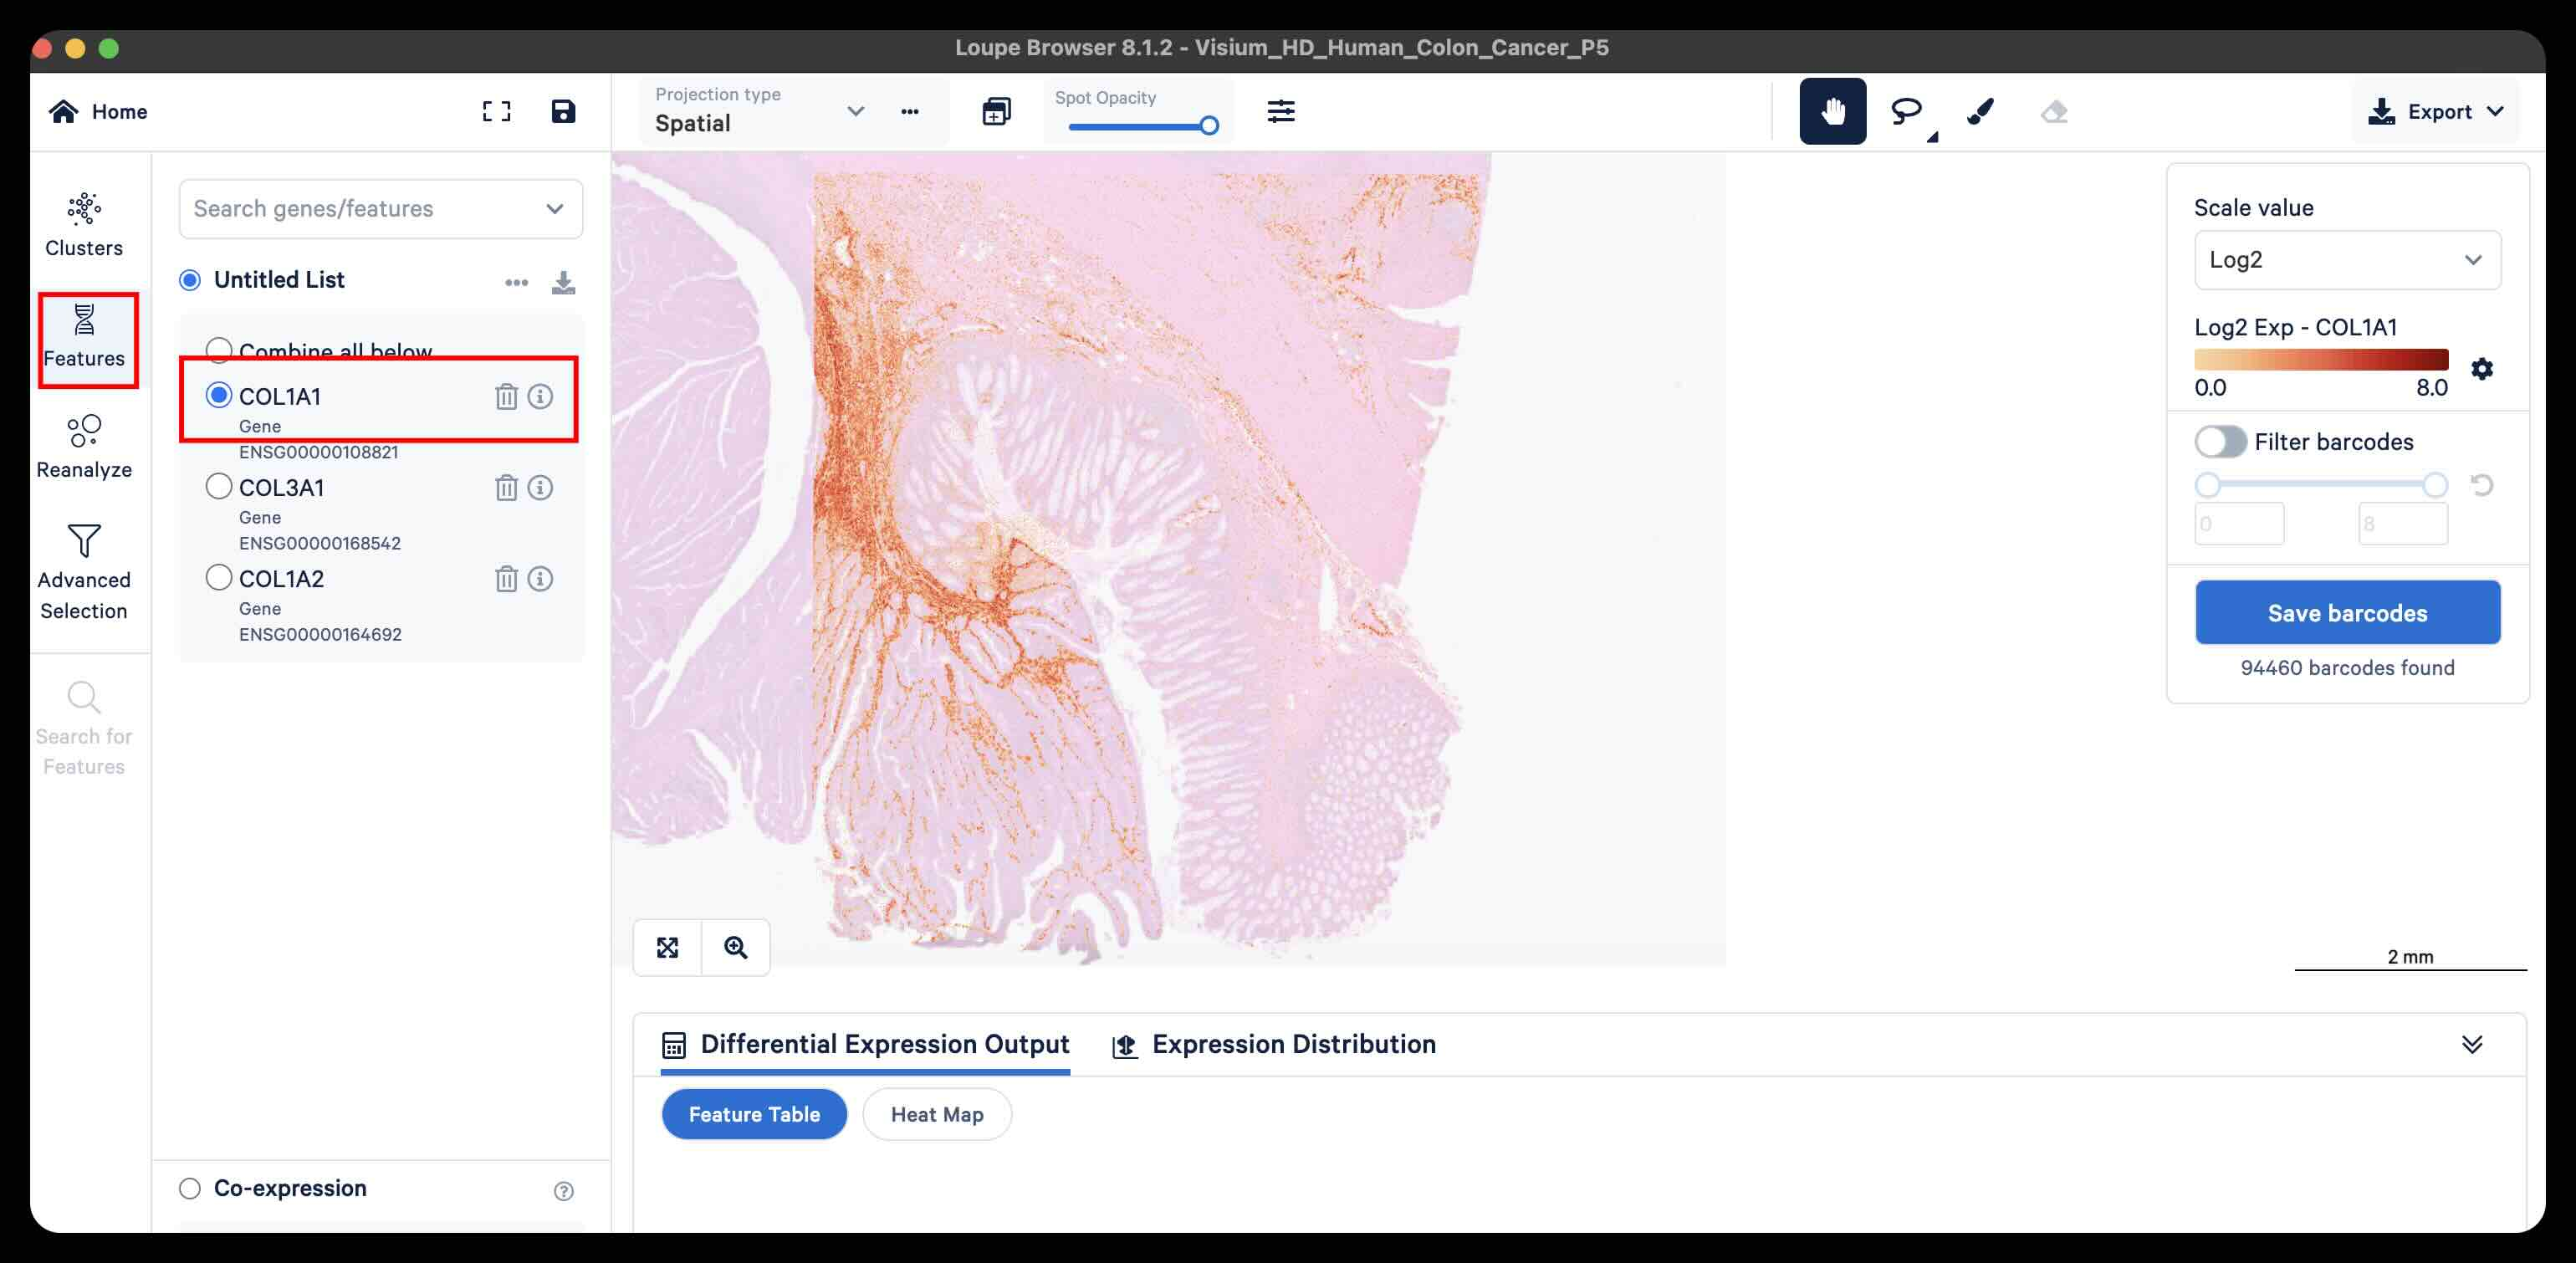

- Normal adjacent tissue

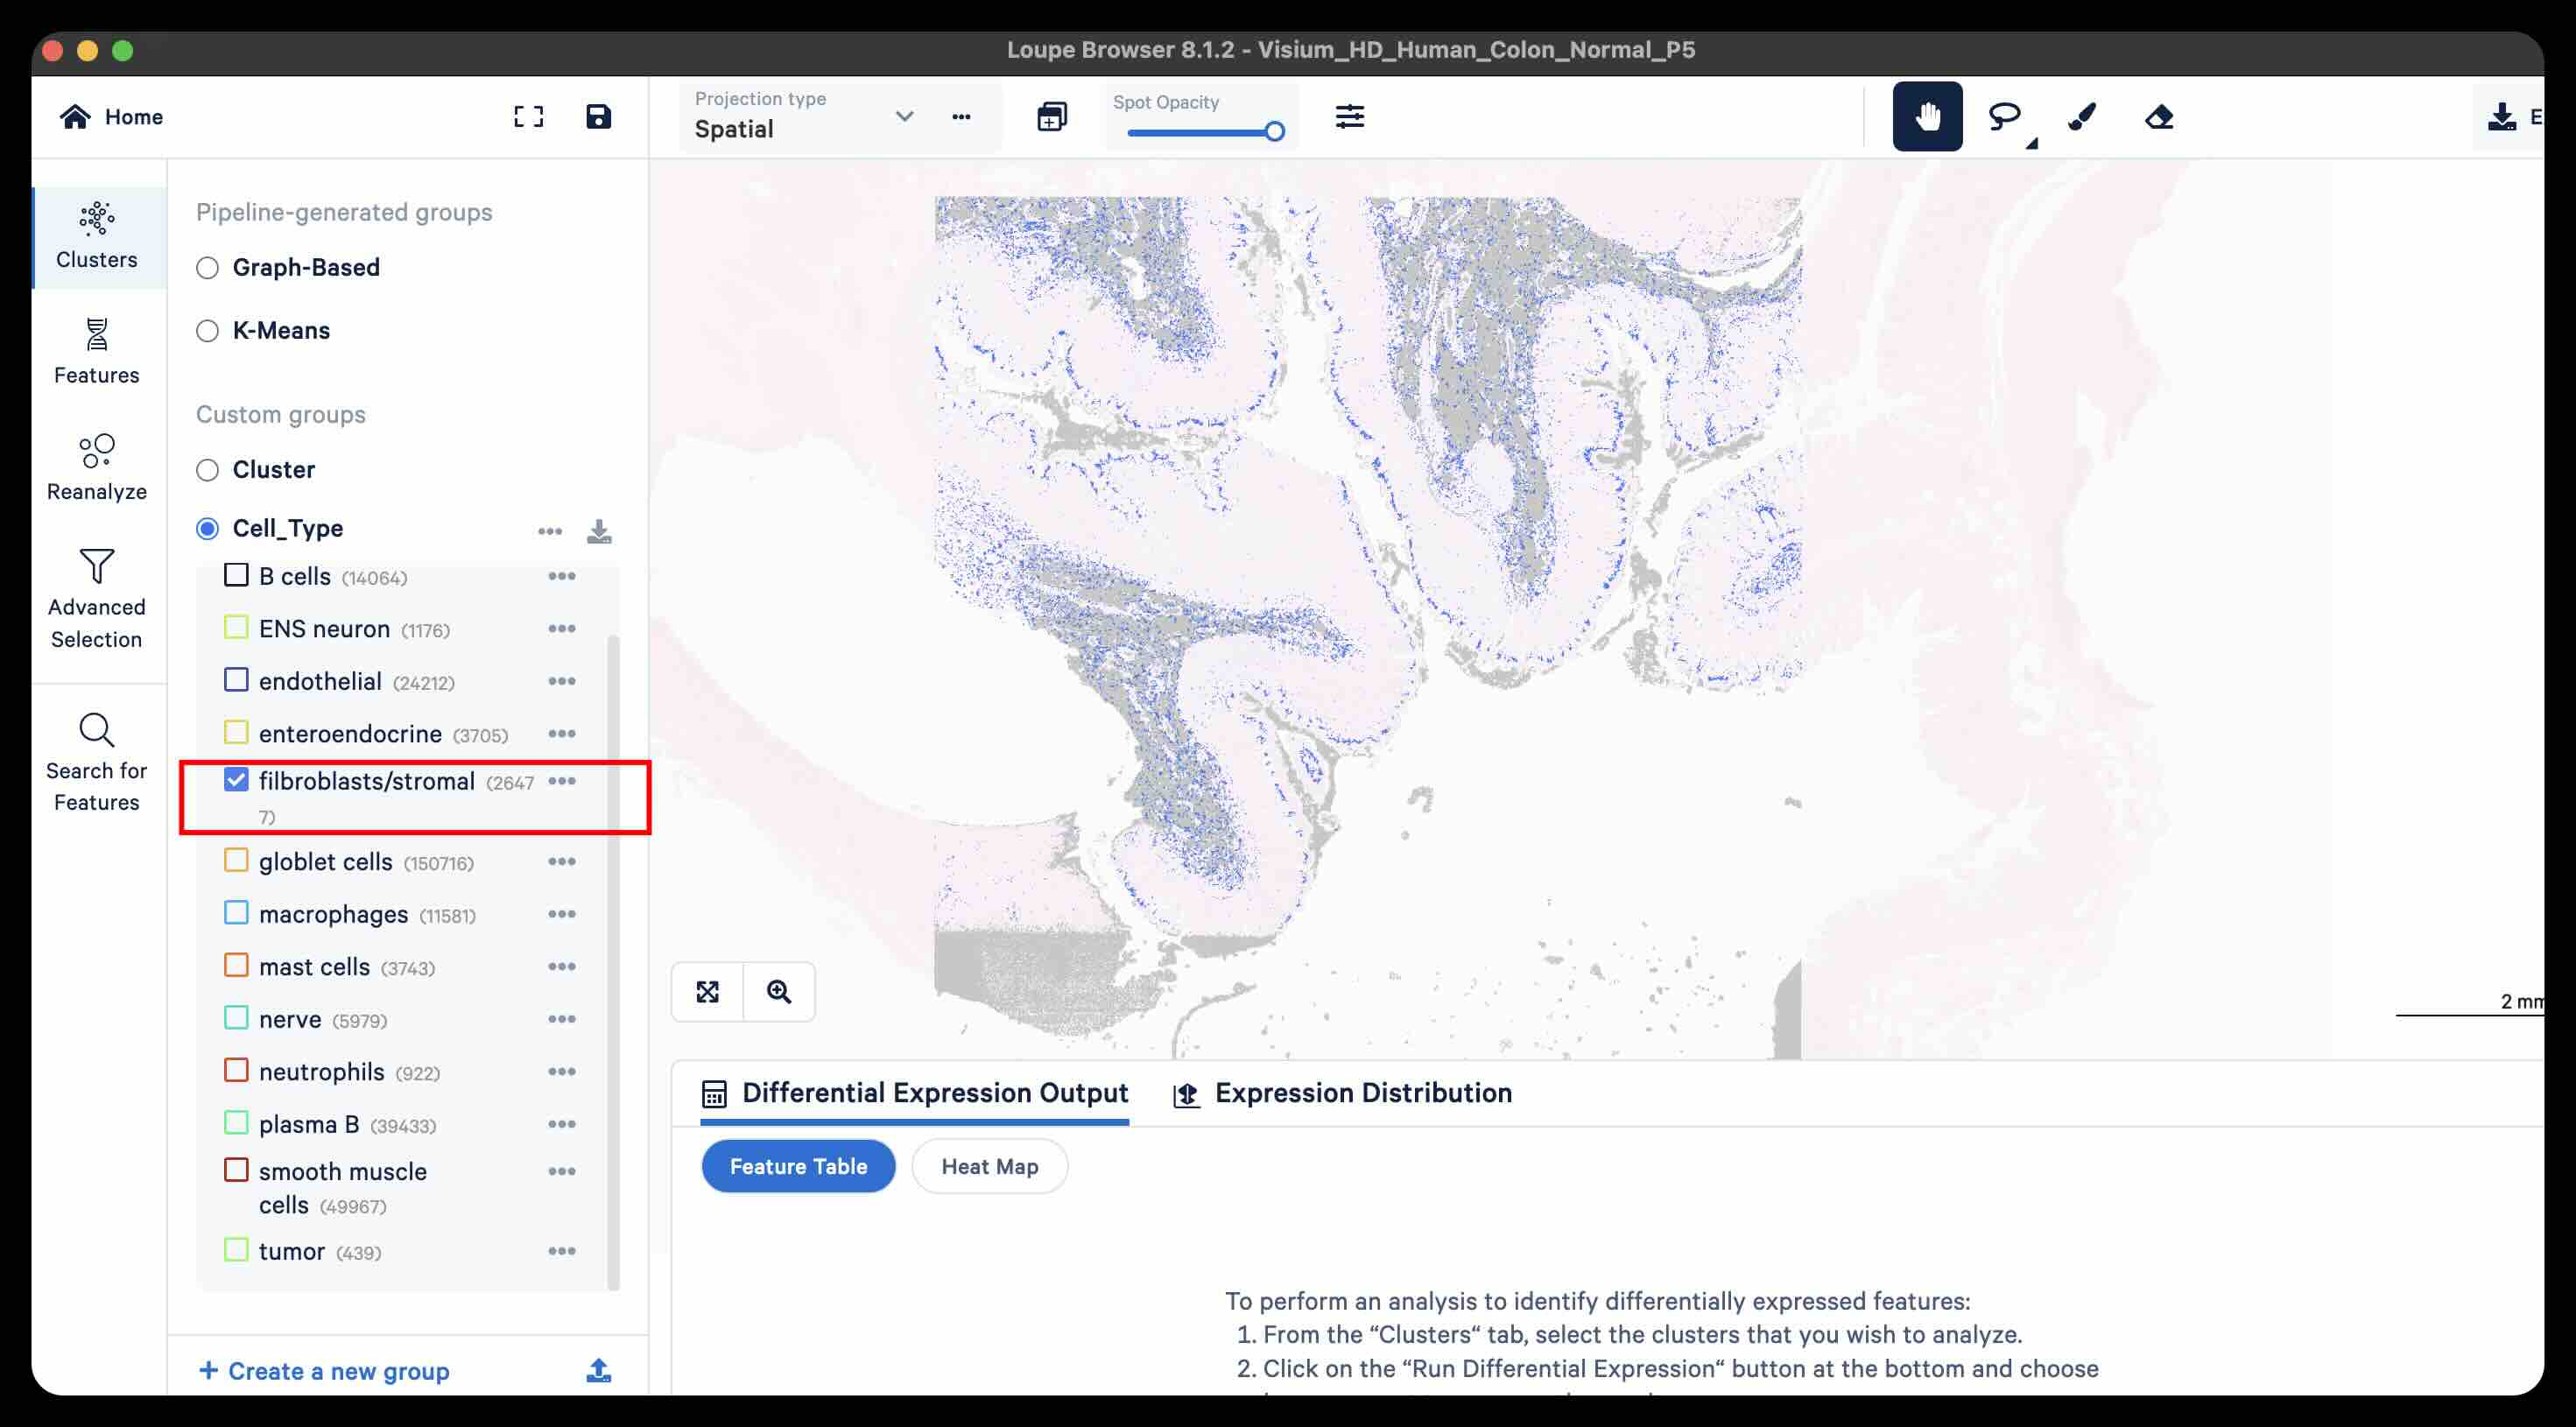

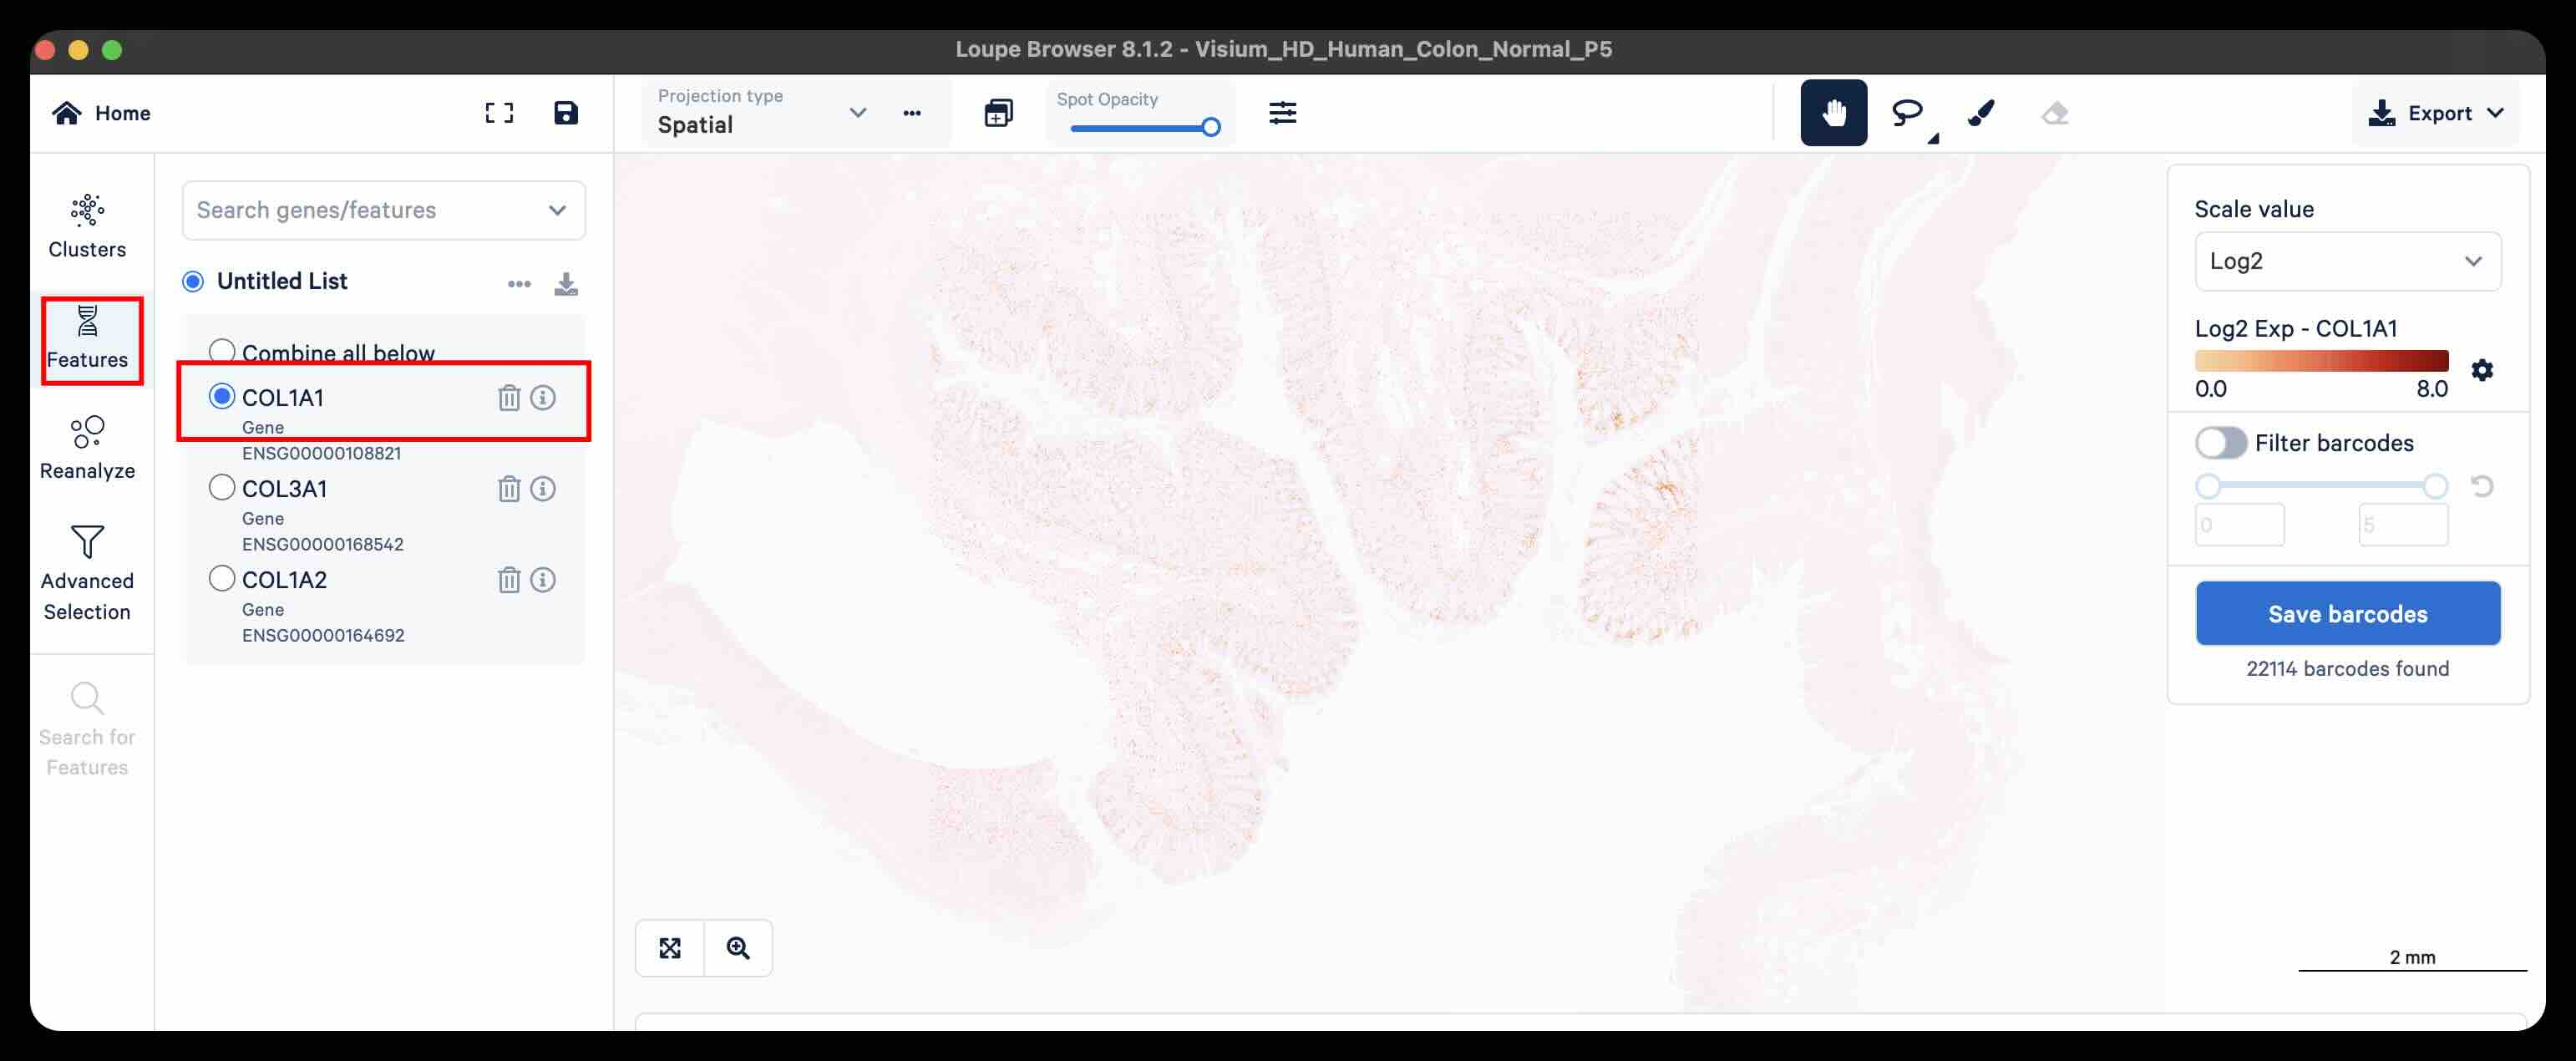